[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/BurgaoTheChamp/ML_CFD/blob/main/ML-CFD.ipynb)

# Deep Learning 

## Deep Learning Applied to Computational Fluid Dynamics

Importing the necessary libraries:

In [1]:
# Setup plotting
# from skimage.metrics import structural_similarity as ssim
# import cv2
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
# # Set Matplotlib defaults
# plt.rc('figure', autolayout=True)
# plt.rc('axes', labelweight='bold', labelsize='large',
#        titleweight='bold', titlesize=18, titlepad=10)
# plt.rc('animation', html='html5')

In [2]:
import torch
import numpy as np
import pandas as pd

import operator
from functools import reduce
from functools import partial

from timeit import default_timer



import glob
from PIL import Image


In [3]:
import tensorflow as tf

In [4]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import os

In [5]:
# This part is for the neural network
# import torch.nn as nn
# import torch.nn.functional as F

# from utilities3 import *
# from Adam import Adam

# torch.manual_seed(0)
# np.random.seed(0)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

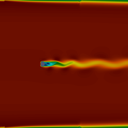

In [7]:
# Folder path/directory
folderDir = "Post-Processing/images/DataBase"

# Image name
imagesPath = folderDir + "/Reynolds300/Reynolds300.0010.png"

# Opening the image
newsize = (128, 128)
img = Image.open(imagesPath).resize(newsize)
# Showing the image
img

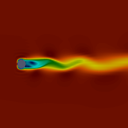

In [8]:
# Folder path/directory
folderDir = "Post-Processing/images/DataBase"

# Image name
imagesPath = folderDir + "/Reynolds300/Reynolds300.0010.png"

# Opening the image
box = (209, 209, 627, 627)
newsize = (128, 128)
img2 = Image.open(imagesPath).crop(box).resize(newsize)
# Showing the image
img2

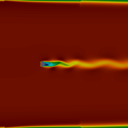

In [9]:
# Image name
imagesPath2 = folderDir + "/Reynolds300/ExtraForComparison/Reynolds300.0020.png"

# Opening the image
newsize = (128, 128)
img3 = Image.open(imagesPath2).resize(newsize)

# Showing the image
img3

In [12]:
def imageLoadGrey(image):
    "Converts an image to greyscale and return an array about it"
    return np.array(image.convert("L"))

def imageLoad(image):
    "Converts an image to an array and return it"
    return np.array(image)

def imageNormalization(image, plot = False, Norm = False):
        "Normalize a grayscales a image"
        _min = np.amin(image)
        _max = np.amax(image)

        norm = 255.0
        if Norm:
            norm = 1.0
            imageNorm = norm * (image - _min) / (_max - _min)
            imageNorm = np.float64(imageNorm)
        else:
            imageNorm = norm * (image - _min) / (_max - _min)
            imageNorm = np.uint8(imageNorm)

        if plot:
            plt.imshow(imageNorm)
            plt.axis("off")
            plt.show()

        return imageNorm

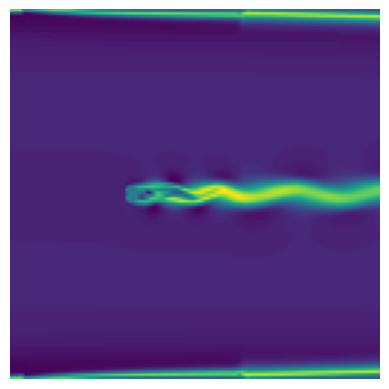

array([[0.76351351, 0.77027027, 0.77702703, ..., 0.29054054, 0.29054054,
        0.29054054],
       [0.16891892, 0.18243243, 0.18918919, ..., 0.54054054, 0.52702703,
        0.52027027],
       [0.00675676, 0.        , 0.        , ..., 0.90540541, 0.90540541,
        0.90540541],
       ...,
       [0.01351351, 0.00675676, 0.        , ..., 0.90540541, 0.90540541,
        0.90540541],
       [0.14189189, 0.17567568, 0.18243243, ..., 0.54054054, 0.52702703,
        0.51351351],
       [0.71621622, 0.76351351, 0.77702703, ..., 0.29054054, 0.29054054,
        0.28378378]])

In [13]:
imageNormalization(img.convert("L"), True, True)

In [14]:
# 3d array to hold the data
ImagesReynolds3D = []
ImagesReynolds3DNormal = []
ImagesReynolds3DGrey = []
# iterate over folders
labels = []
Reynolds = 100
MaxReynolds = 300
while(Reynolds <= MaxReynolds):
    # appending the Reynolds numbers as labels into the array label 
    holder = []
    holder.append(Reynolds/MaxReynolds)
    labels.append(holder)
    # 2d array of size 10 to hold the images per reynolds number
    ImagesReynolds = []
    ImagesReynoldsNormal = []
    ImagesReynoldsGrey = []
    # importing and resizing to 128x128, all images from folder
    for filename in glob.glob(folderDir + "/Reynolds" + str(Reynolds) + "/*.png"):
        # opening the images and resizing them
        imageResized = Image.open(filename).crop(box).resize(newsize)
        # Appending an image to the 2d list
        ImagesReynolds.append(imageLoad(imageResized))
        ImagesReynoldsGrey.append(imageLoadGrey(imageResized))
        ImagesReynoldsNormal.append(imageNormalization(imageResized.convert("L"), Norm = True))
    # Appending the 2d image list to the 3d list of size 10
    ImagesReynolds3D.append(ImagesReynolds)
    ImagesReynolds3DGrey.append(ImagesReynoldsGrey)
    ImagesReynolds3DNormal.append(ImagesReynoldsNormal)
    #Increasing the Reynolds number
    Reynolds = Reynolds + 10
#ImagesReynolds3D

In [15]:
# 3d array to hold the data
Reynolds = 100
ImagesReynolds3DTarget = []
ImagesReynolds3DNormalTarget = []
ImagesReynolds3DGreyTarget = []
# iterate over folders
while(Reynolds <= MaxReynolds):
    # 2d array of size of temporal serie to hold the images per reynolds number
    ImagesReynoldsTarget = []
    ImagesReynoldsNormalTarget = []
    ImagesReynoldsGreyTarget = []
    # importing and resizing to 128x128, for one image from the folders
    filename = folderDir + "/Reynolds" + str(Reynolds) + "/ExtraForComparison/Reynolds" + str(Reynolds) + ".0011.png"
    # opening the image and resizing it
    imageResizedTarget = Image.open(filename).crop(box).resize(newsize)
    # Appending an image to the 2d list
    ImagesReynoldsTarget.append(imageLoad(imageResizedTarget))
    ImagesReynoldsGreyTarget.append(imageLoadGrey(imageResizedTarget))
    ImagesReynoldsNormalTarget.append(imageNormalization(imageResizedTarget.convert("L"), Norm = True))
    # Appending the 2d image list to the 3d list of size of the temporal serie
    ImagesReynolds3DTarget.append(ImagesReynoldsTarget)
    ImagesReynolds3DGreyTarget.append(ImagesReynoldsGreyTarget)
    ImagesReynolds3DNormalTarget.append(ImagesReynoldsNormalTarget)
    #Increasing the Reynolds number
    Reynolds = Reynolds + 10
#ImagesReynolds3D

In [16]:
ImagesReynolds3DTarget = np.array(ImagesReynolds3DTarget)
ImagesReynolds3DTarget.shape

(21, 1, 128, 128, 3)

In [17]:
ImagesReynolds3DNormalTarget = np.array(ImagesReynolds3DNormalTarget)
ImagesReynolds3DNormalTarget.shape

(21, 1, 128, 128)

In [18]:
ImagesReynolds3DGreyTarget = np.array(ImagesReynolds3DGreyTarget)
ImagesReynolds3DGreyTarget.shape

(21, 1, 128, 128)

In [19]:
ImagesReynolds3D = np.array(ImagesReynolds3D)
ImagesReynolds3D.shape

(21, 11, 128, 128, 3)

In [20]:
ImagesReynolds3DNormal = np.array(ImagesReynolds3DNormal)
ImagesReynolds3DNormal.shape

(21, 11, 128, 128)

In [21]:
ImagesReynolds3DGrey = np.array(ImagesReynolds3DGrey)
ImagesReynolds3DGrey.shape

(21, 11, 128, 128)

In [302]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(ImagesReynolds3D, ImagesReynolds3DTarget, test_size=0.20, random_state=99, shuffle = True)

In [23]:
data_test.shape

(5, 11, 128, 128, 3)

In [24]:
data_train.shape

(16, 11, 128, 128, 3)

In [25]:
target_test.shape

(5, 1, 128, 128, 3)

In [26]:
target_train.shape

(16, 1, 128, 128, 3)

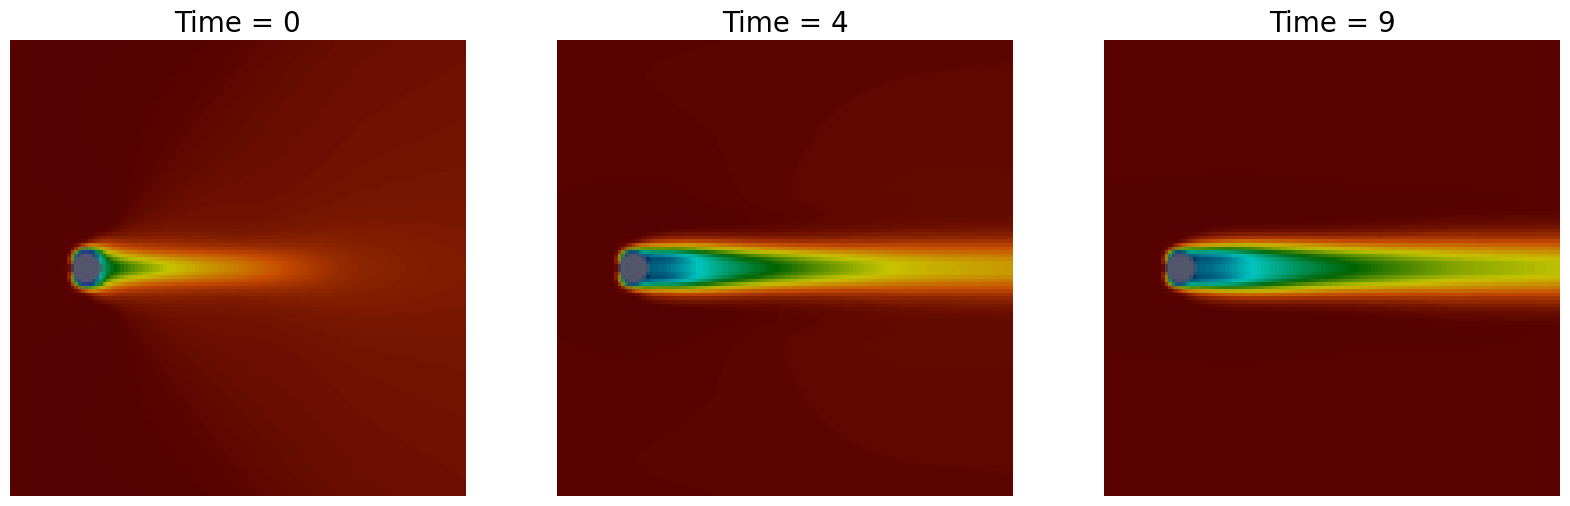

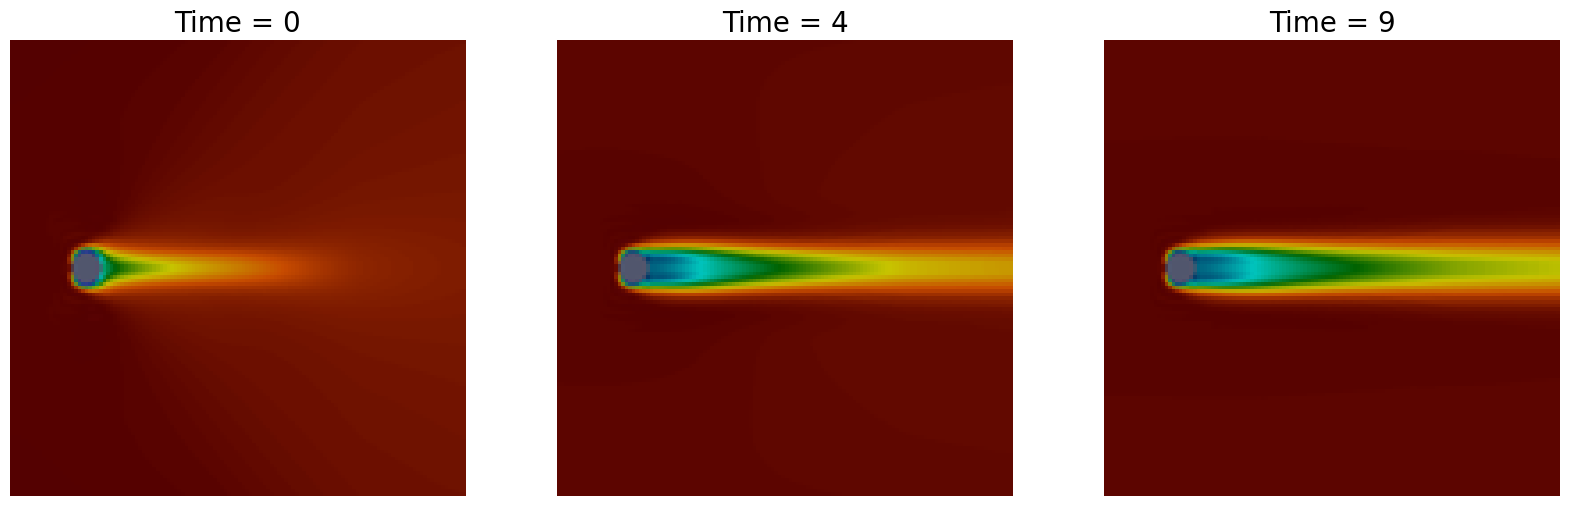

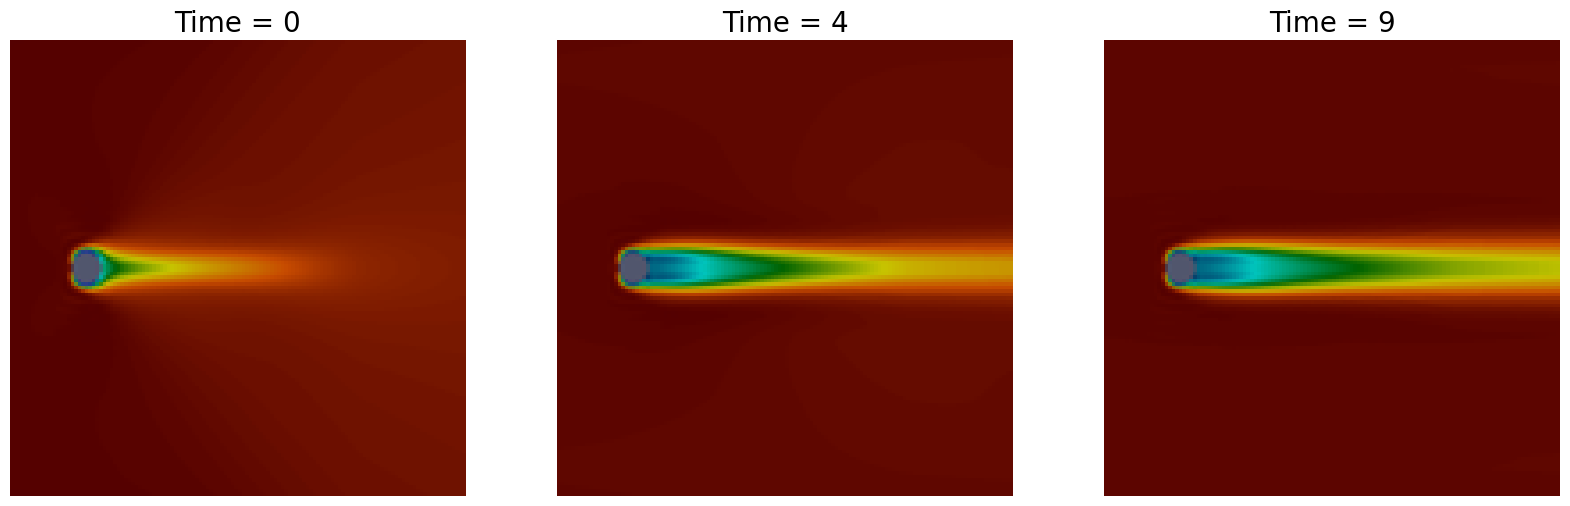

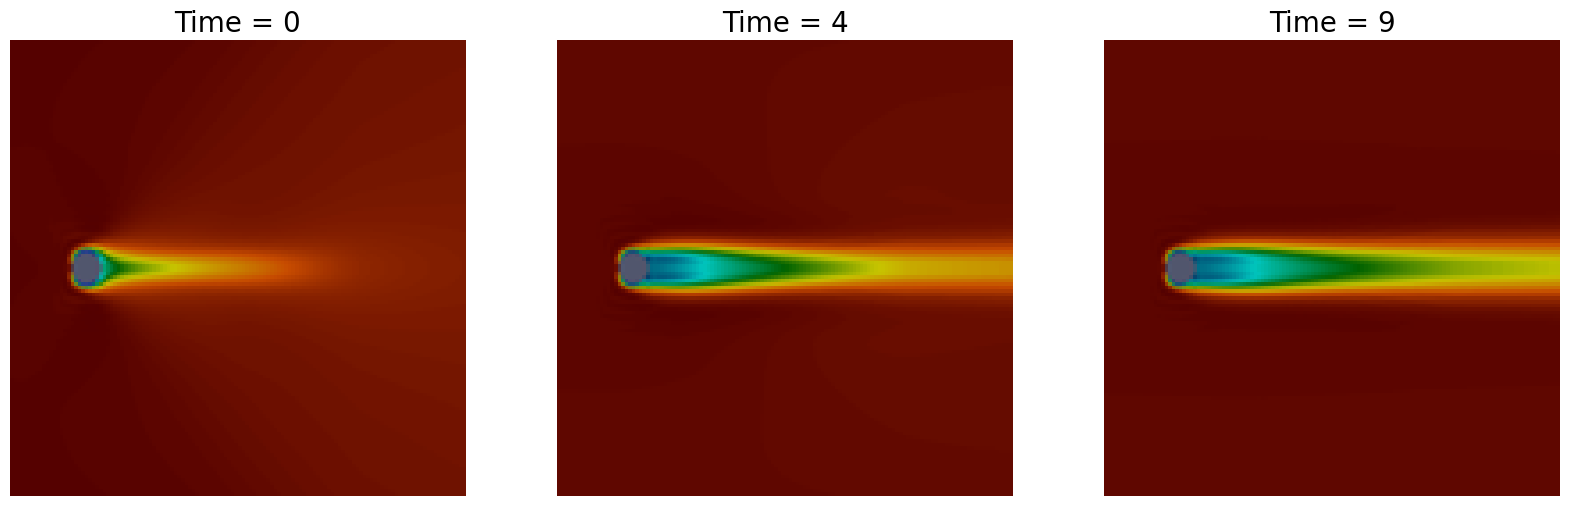

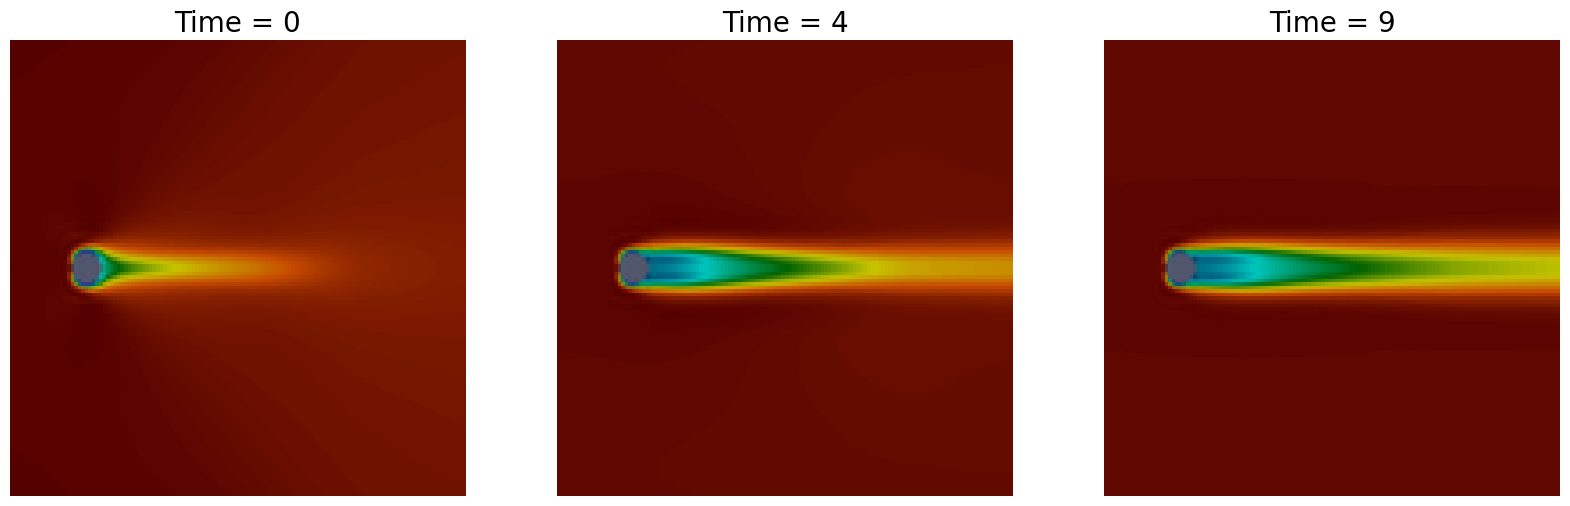

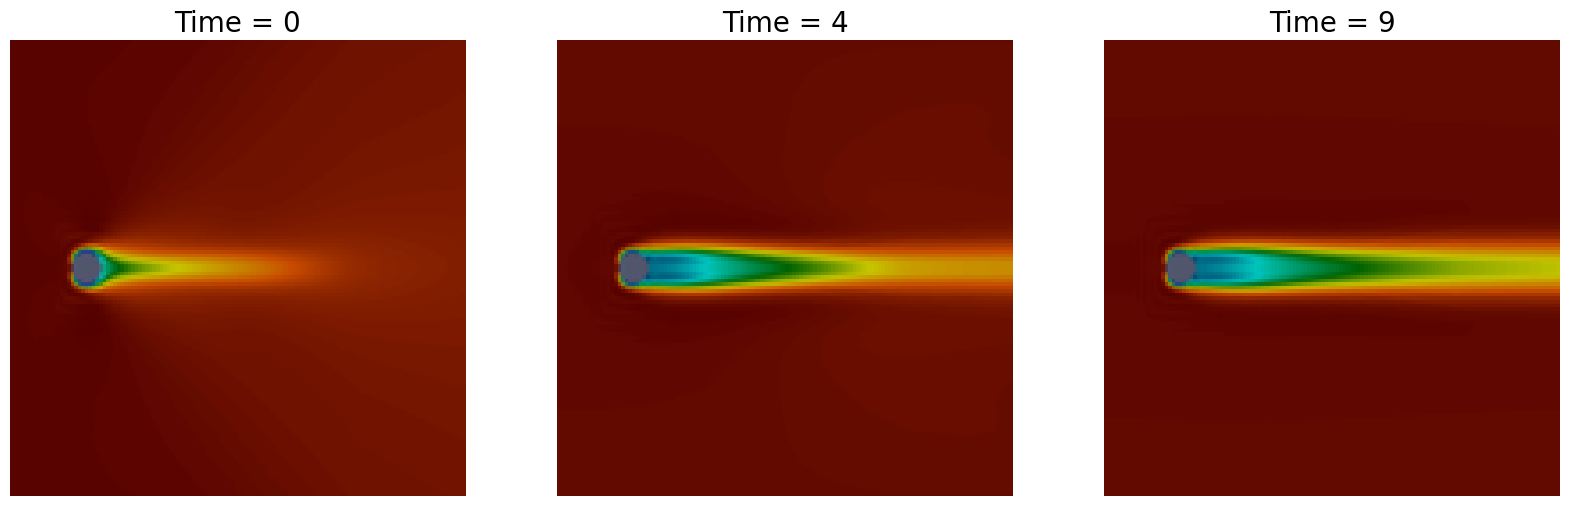

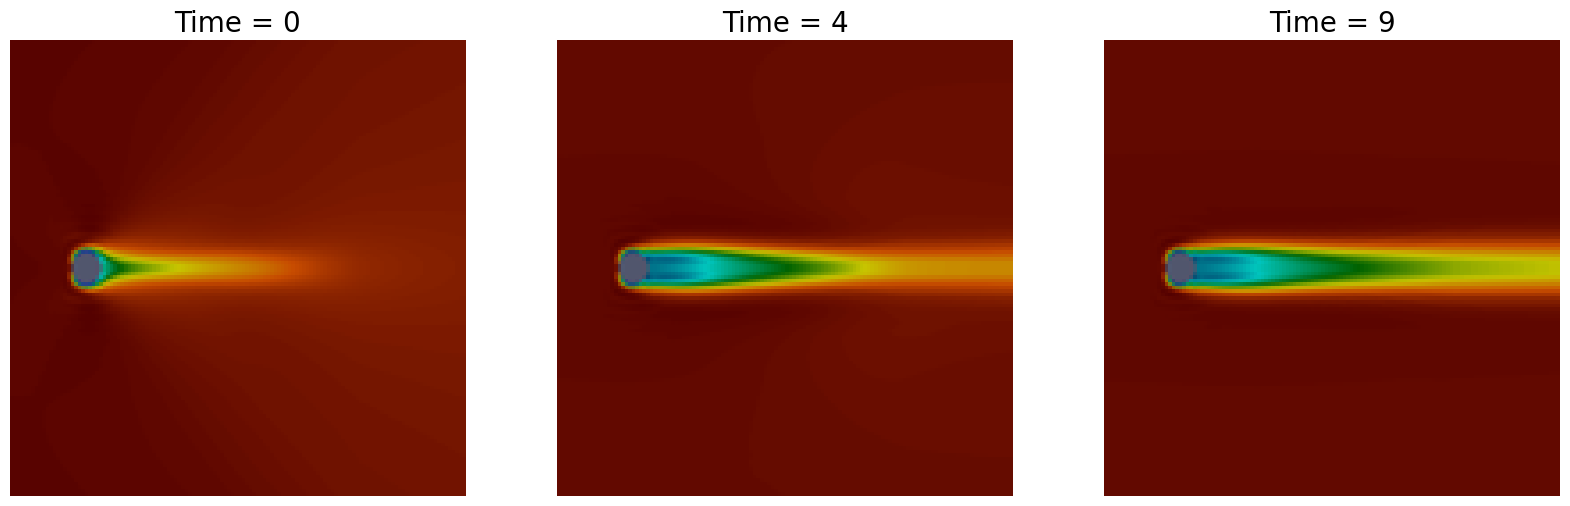

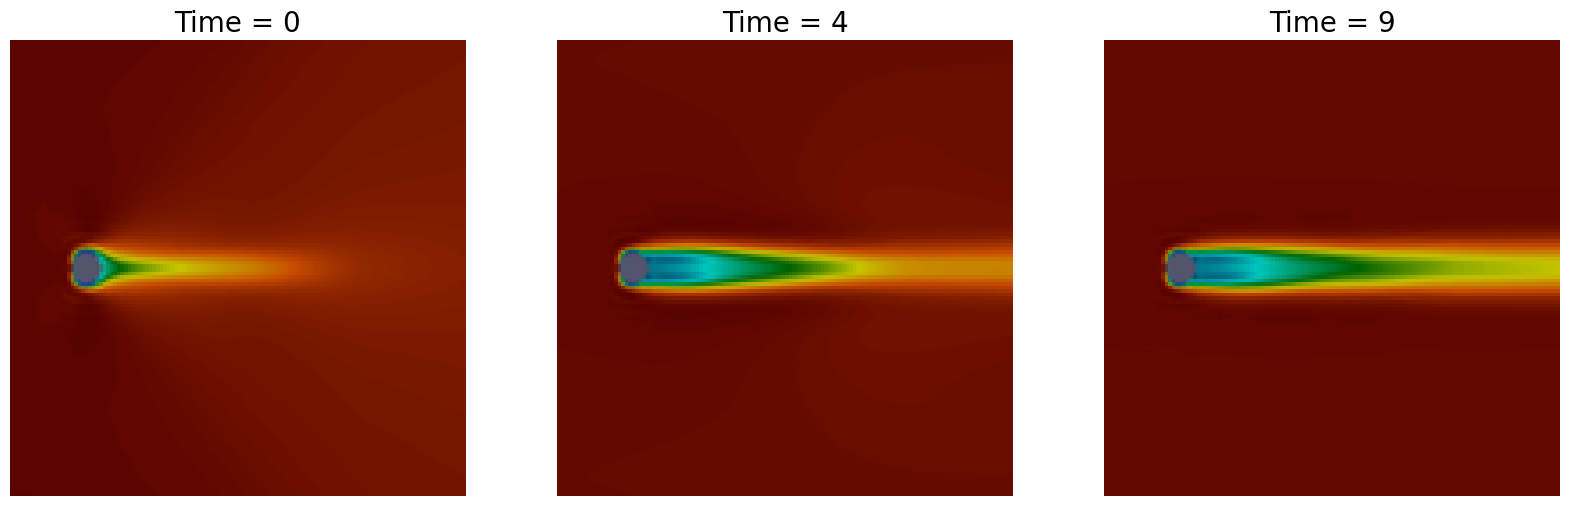

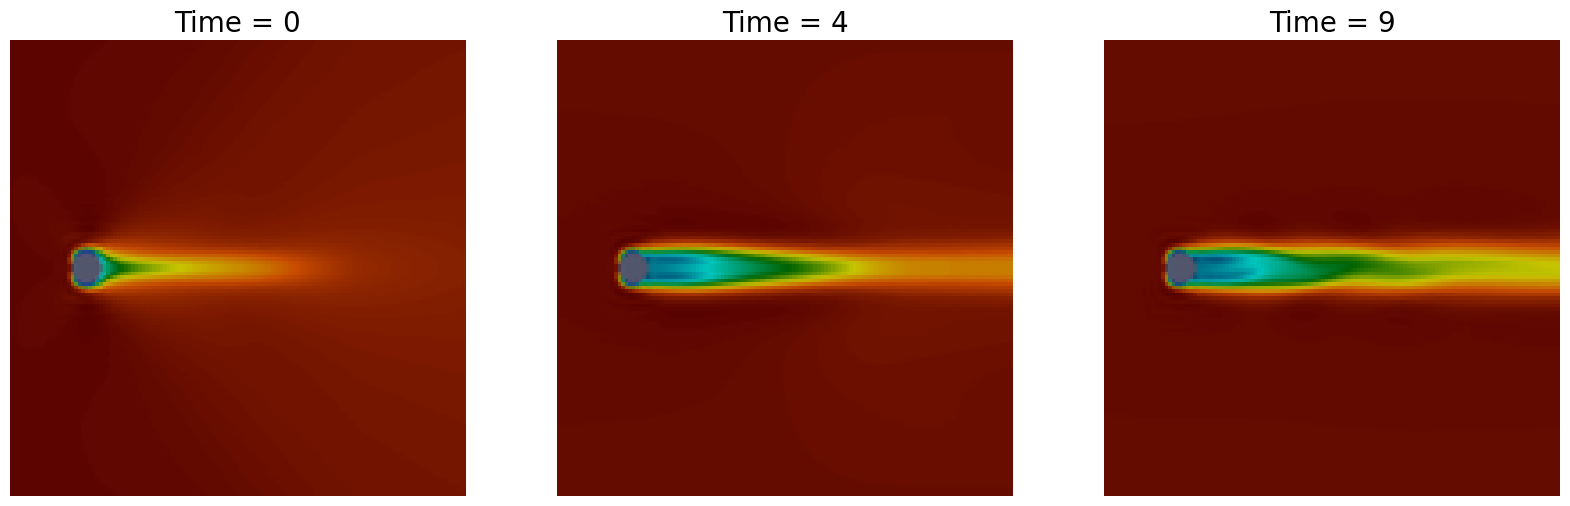

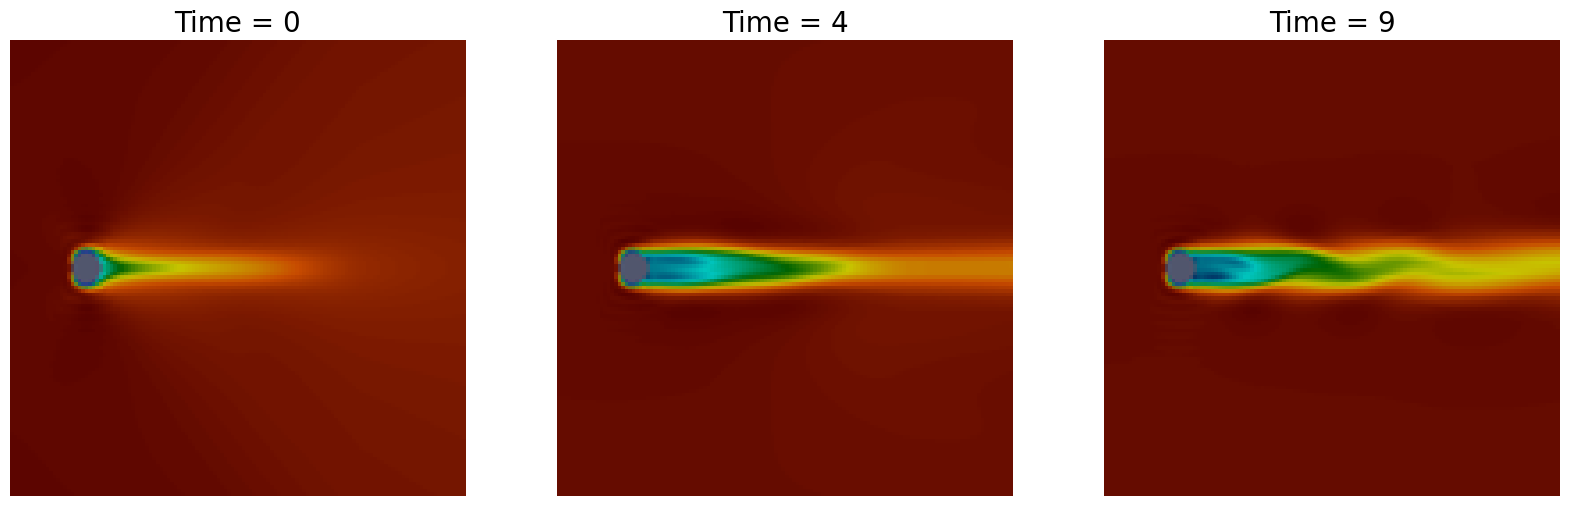

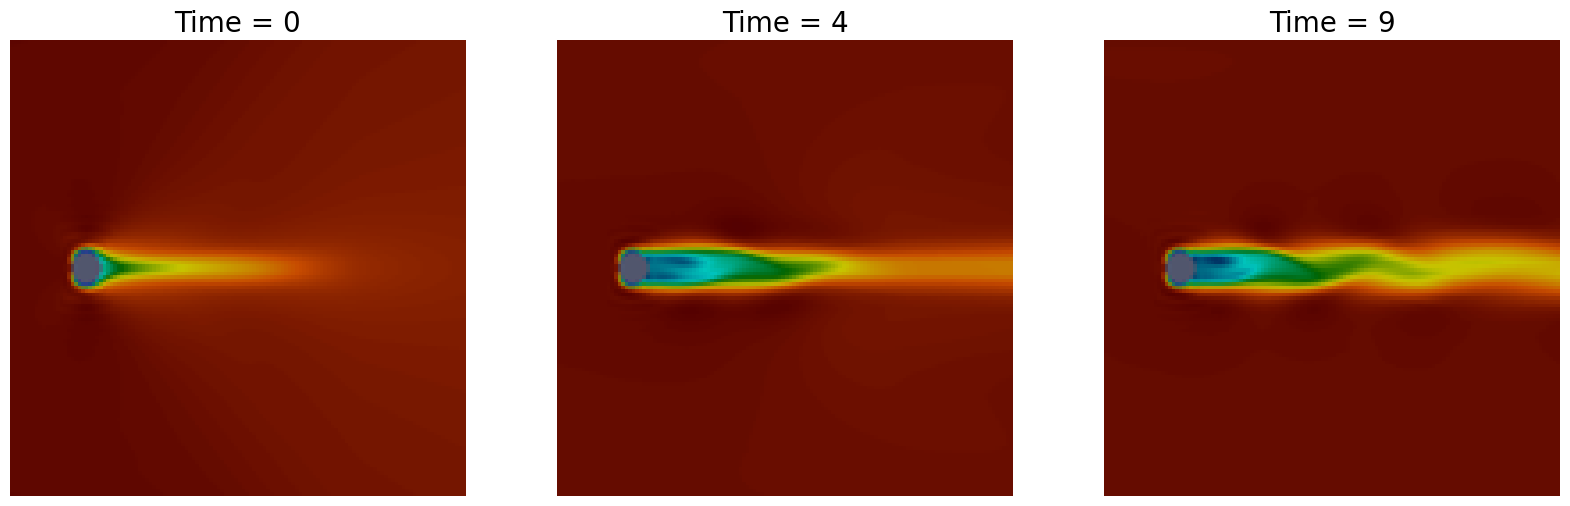

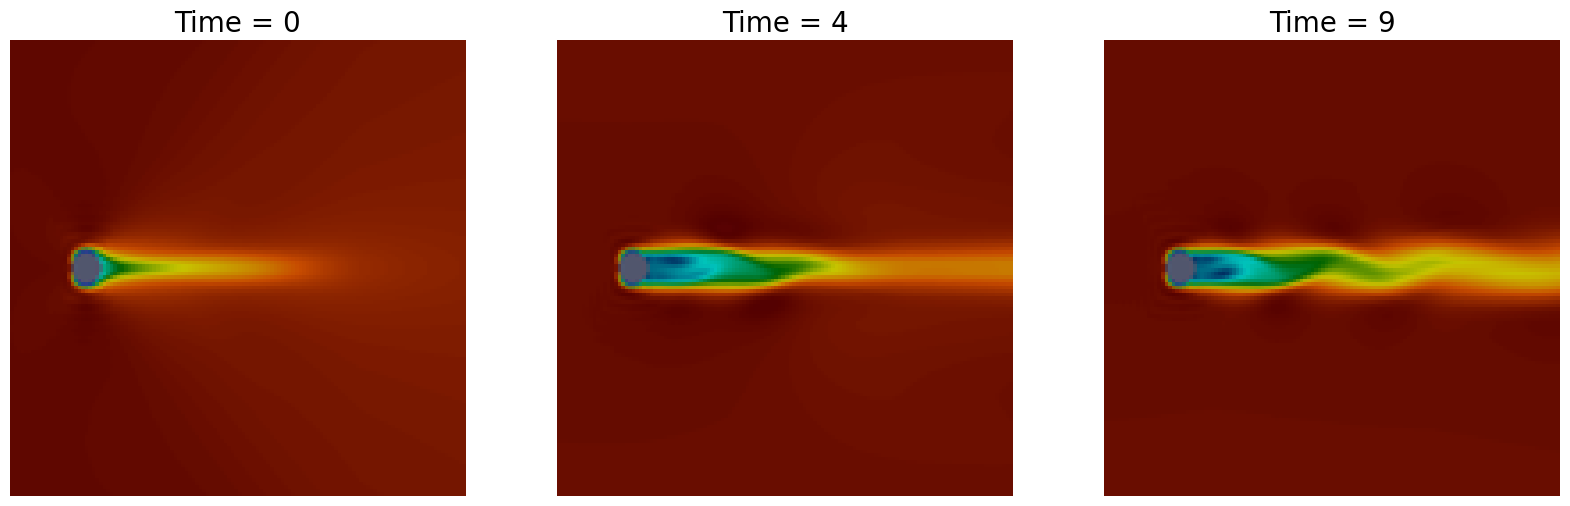

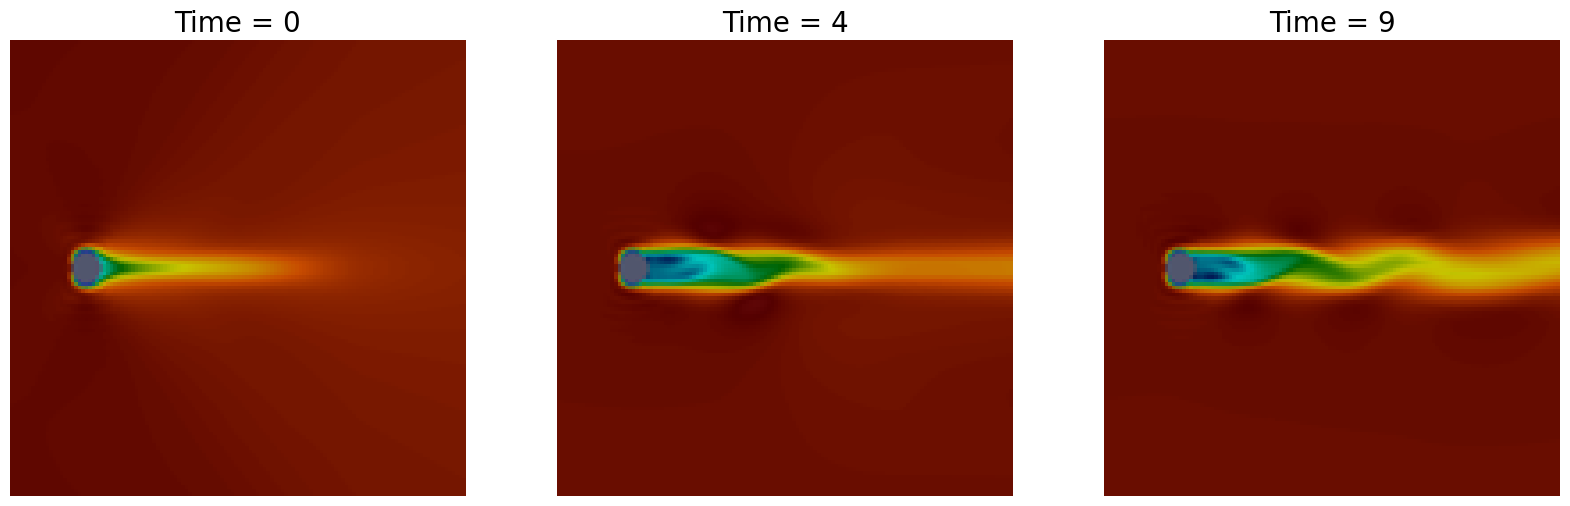

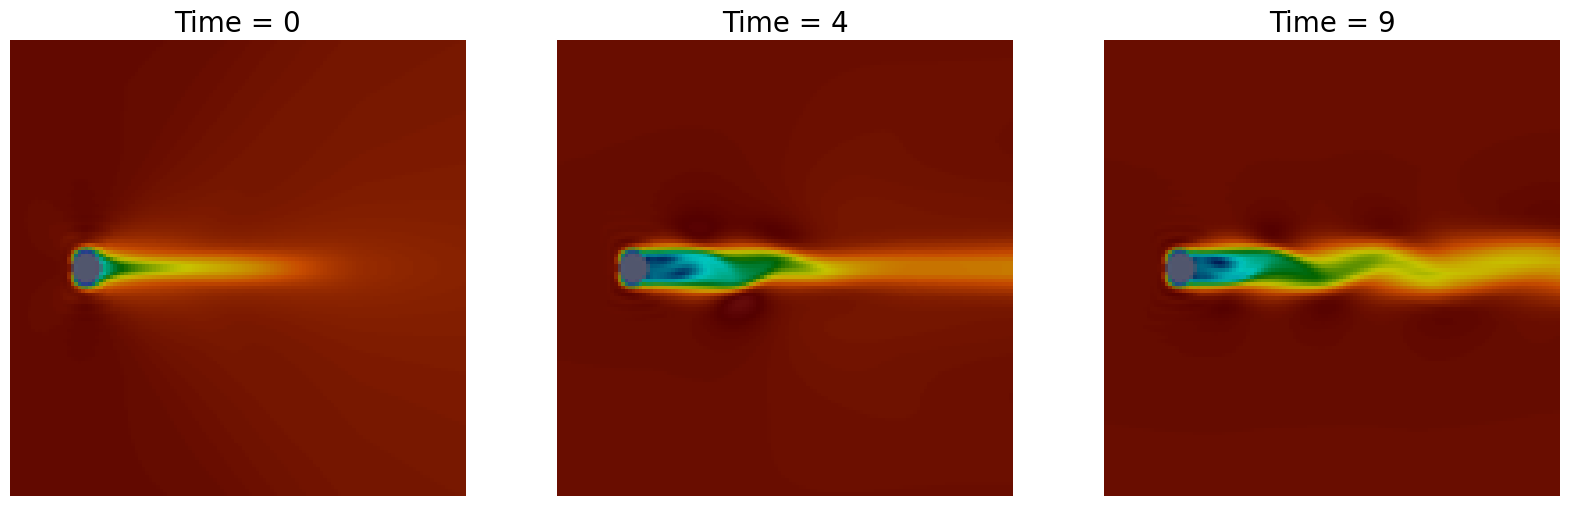

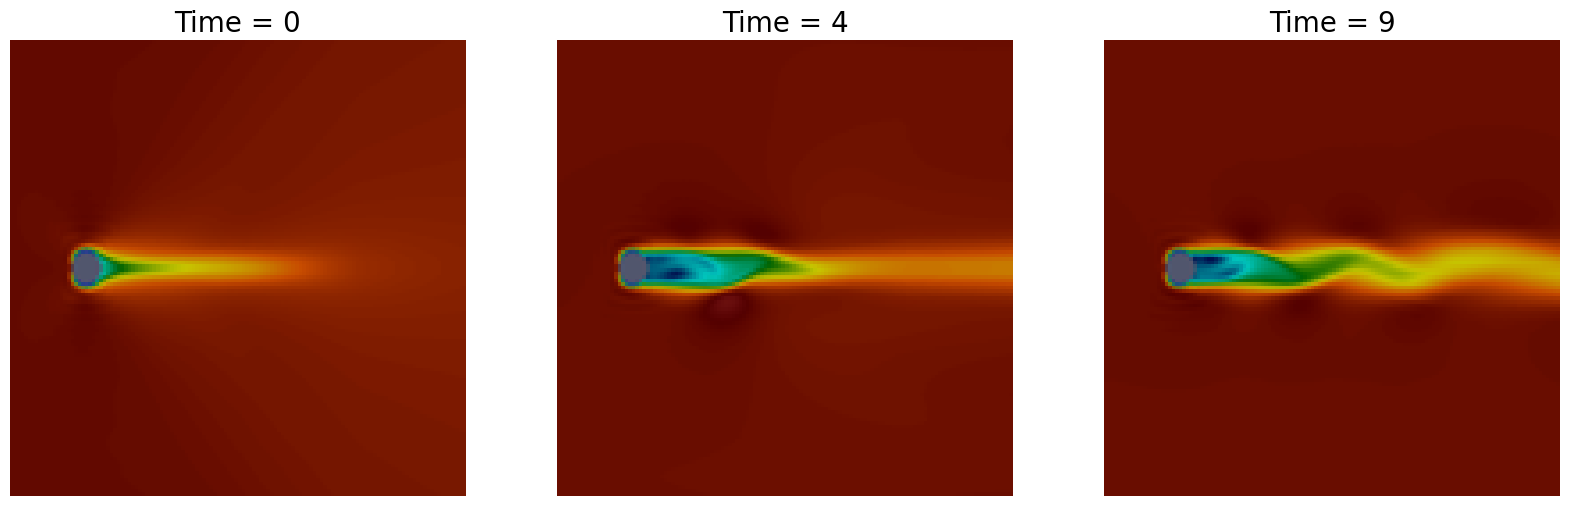

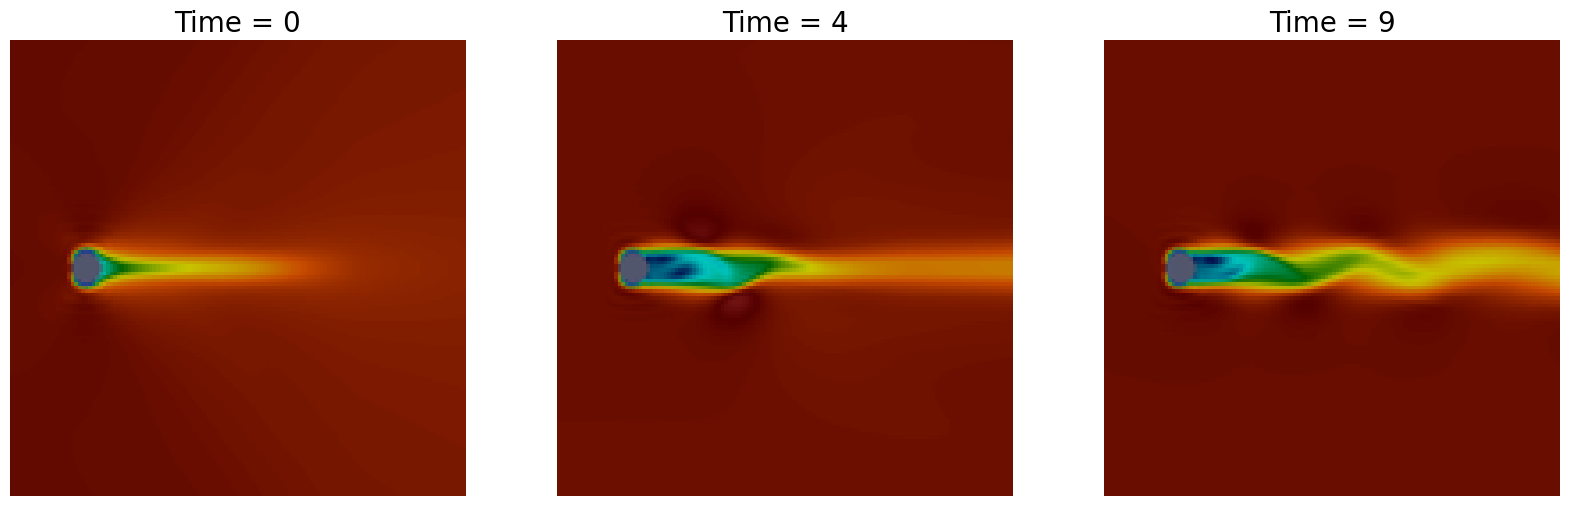

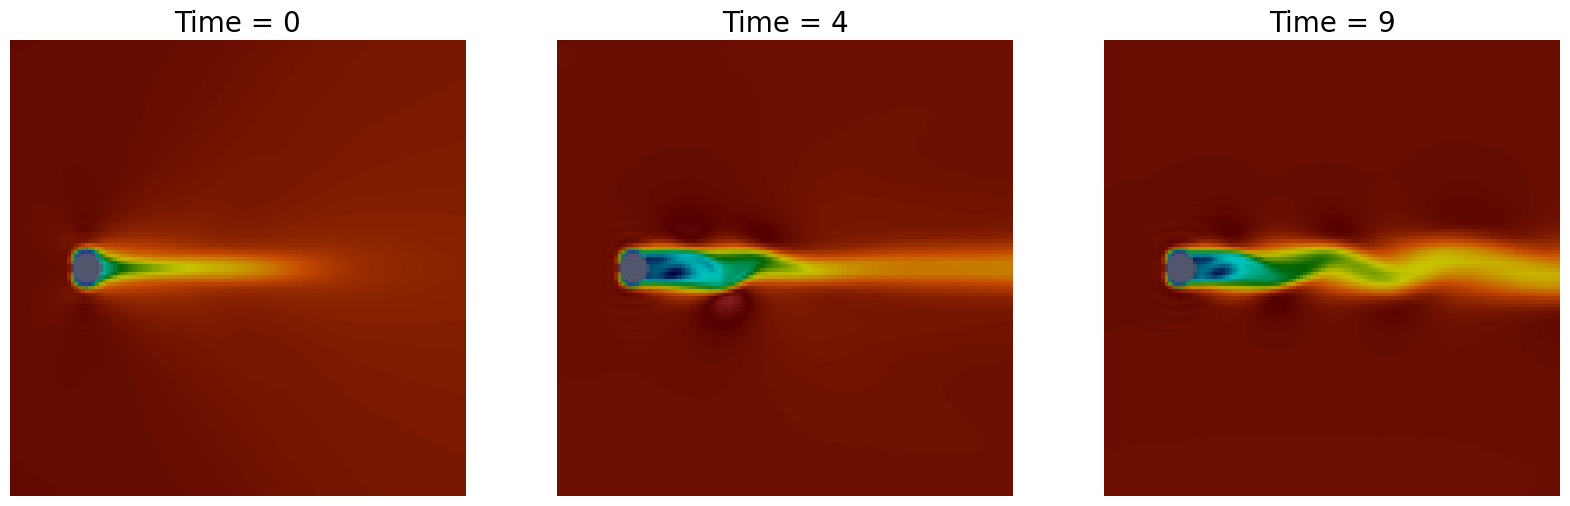

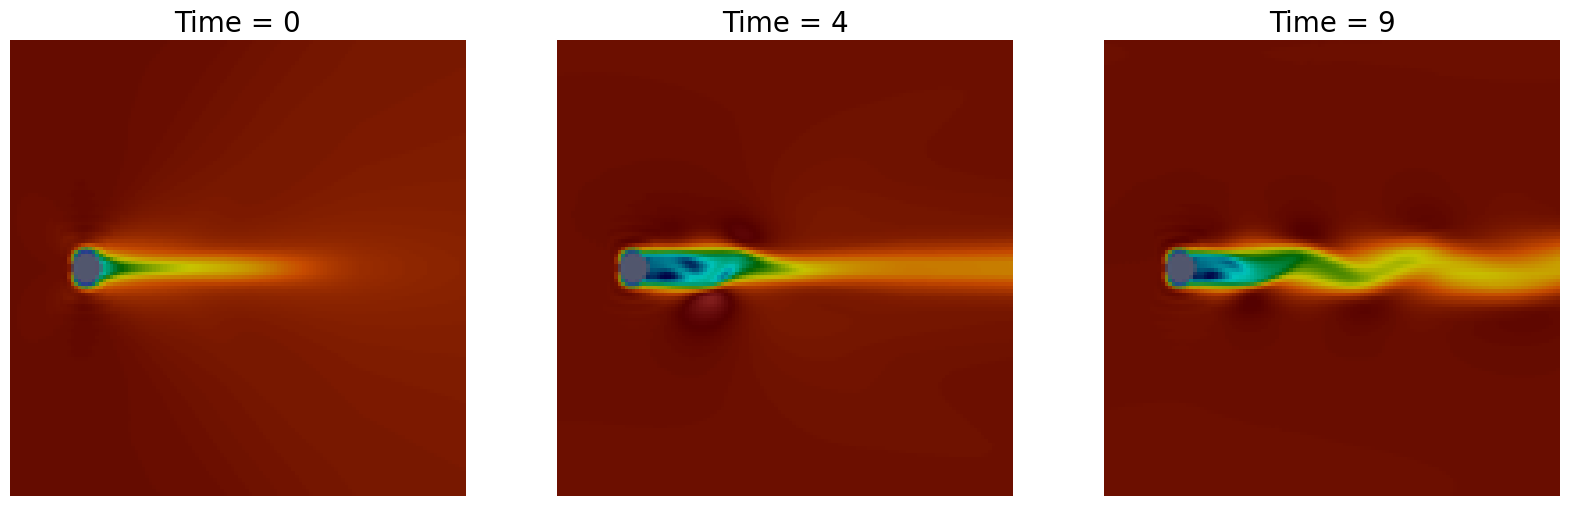

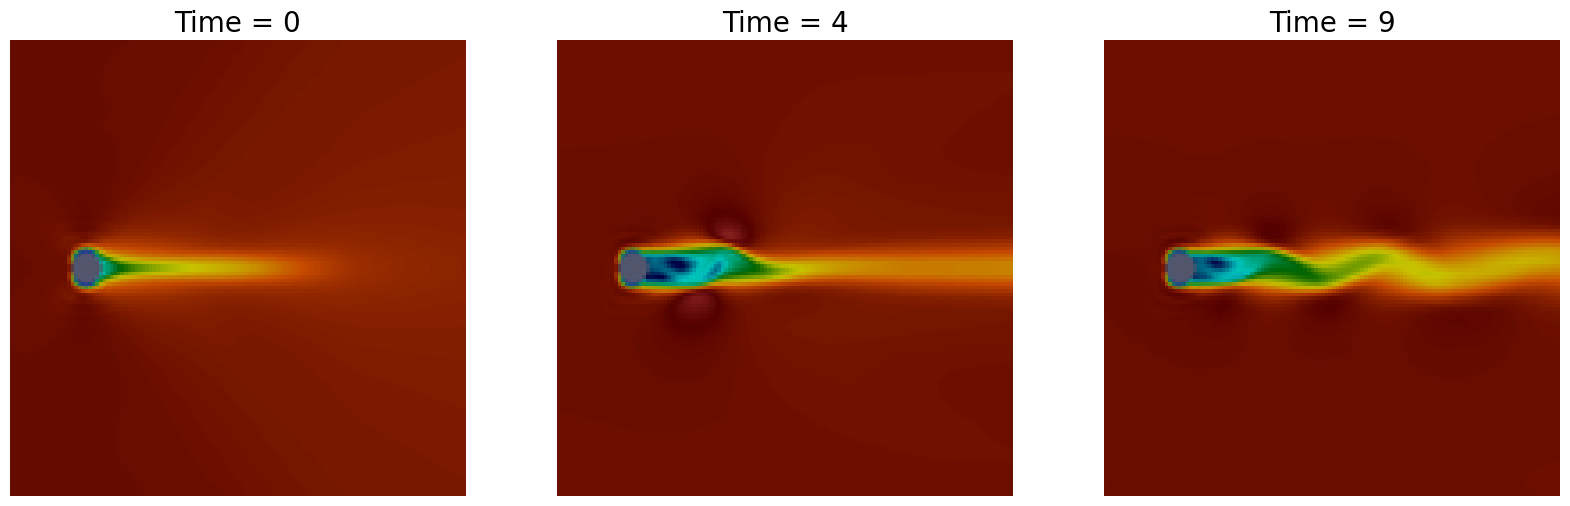

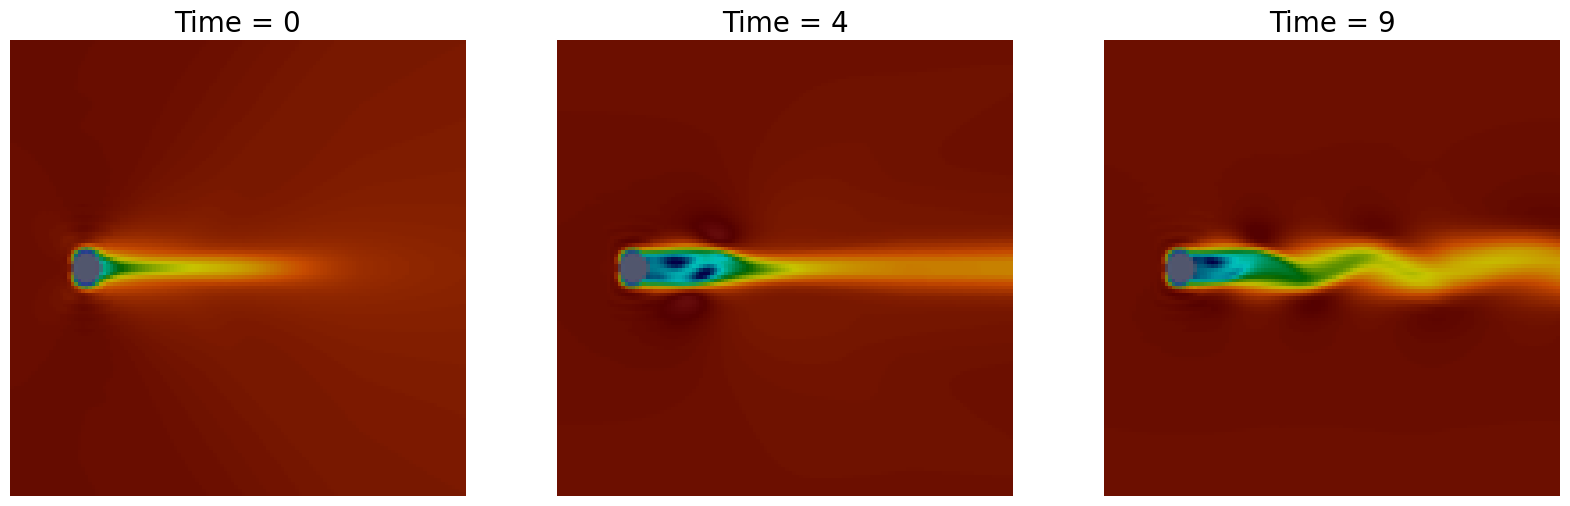

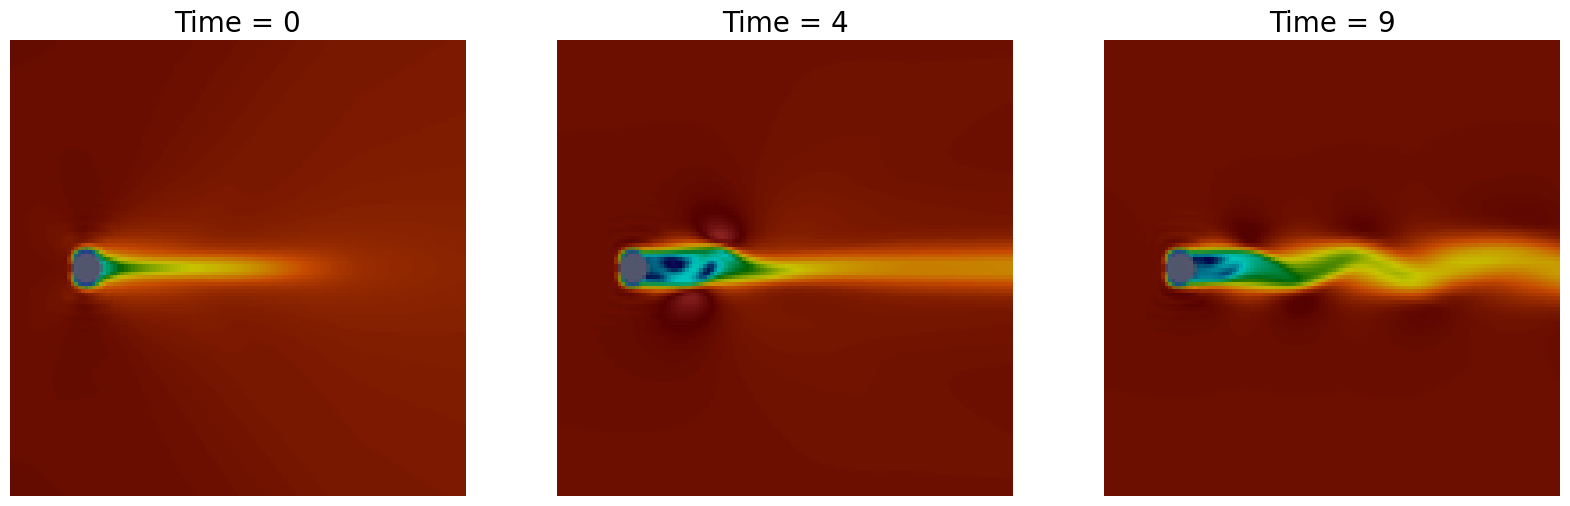

In [29]:
# Plotting imagem from every example
# Config for the sizes of the boxes to be ploted
boxSizeX = 20
boxSizeY = 10
fontsize = 20
# Looping through all Reynolds numbers
for ReynoldsNumber in range(len(ImagesReynolds3D)):
    # Setting the boxes sizes
    fig = plt.figure(figsize=[boxSizeX,boxSizeY])
    # Looping throuhg all times
    i = 1
    for time in range(len(ImagesReynolds3D[ReynoldsNumber])):
        if time == 0 or time == 4 or time == 9:
        # Subplotting every box with 11 timesteps for one example
            plt.subplot(1, 3, i)
            i = i + 1
            # Looping to open every image 
            for image in ImagesReynolds3D[ReynoldsNumber][time]:
                plt.axis('off')
                # Showing every image stored in the array
                plt.imshow(ImagesReynolds3D[ReynoldsNumber][time], cmap=plt.cm.gray, interpolation='nearest')
                # Plotting its images' time step 
                plt.title('Time = %d'%int(time), fontdict={'fontsize': fontsize})
    plt.show()
    fig.savefig("Post-Processing/images/Dataset/Dataset" + str(ReynoldsNumber+1) +".png")

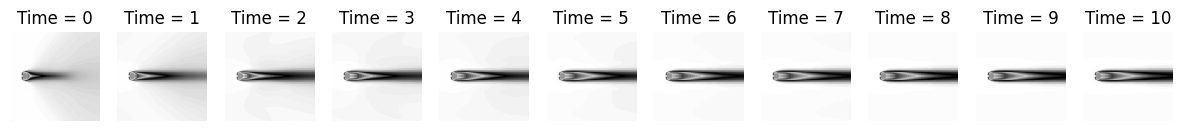

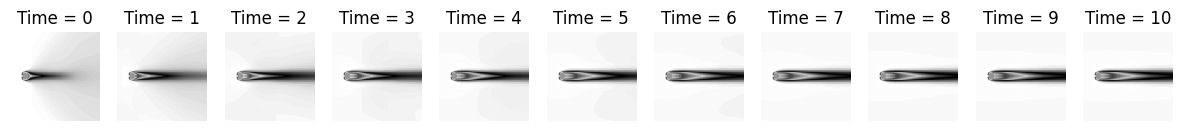

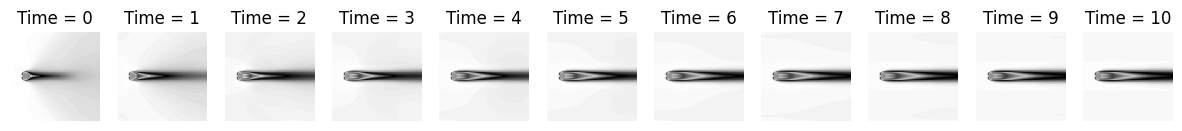

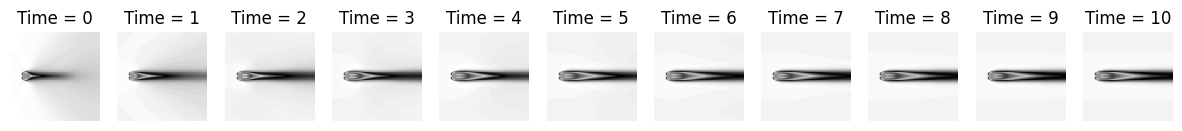

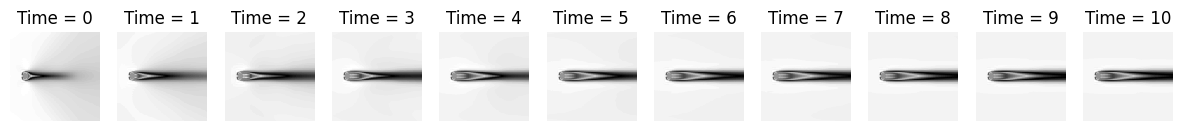

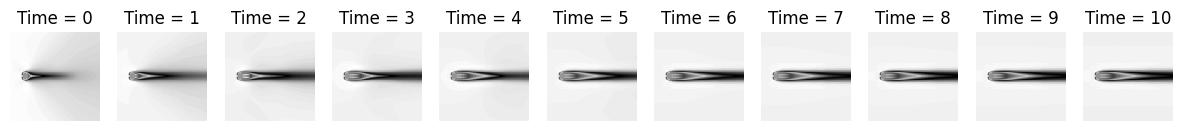

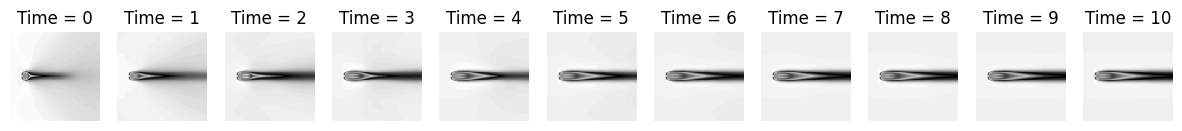

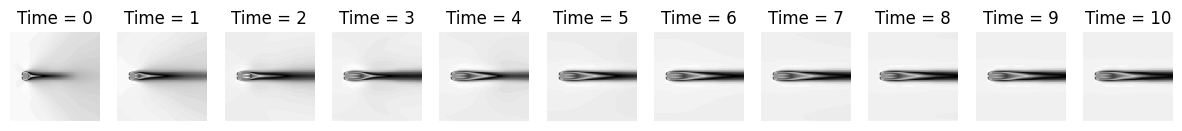

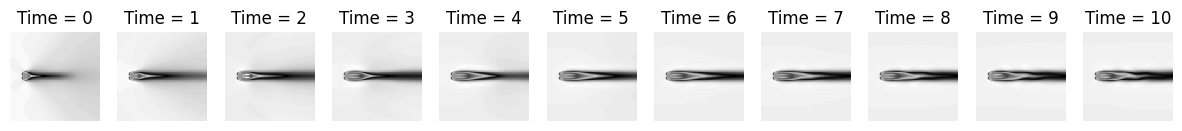

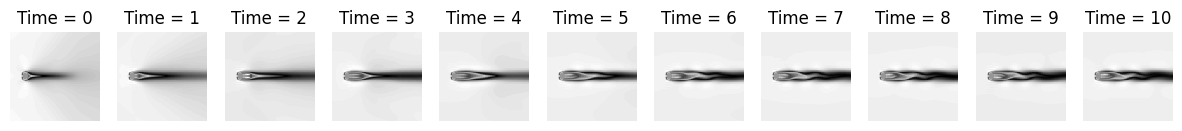

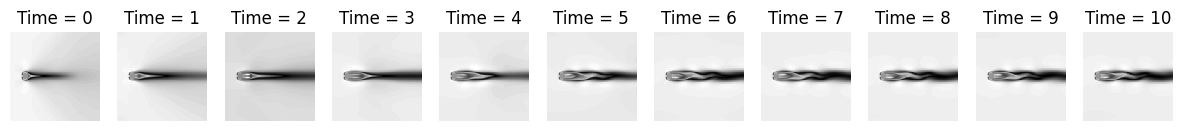

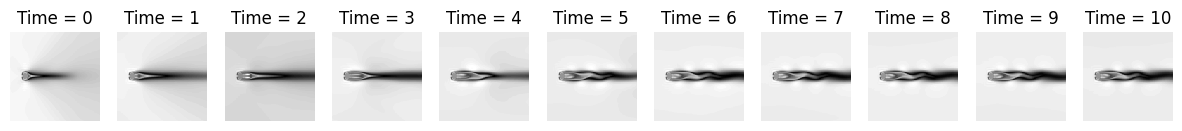

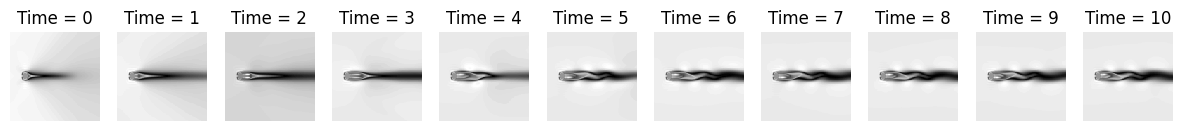

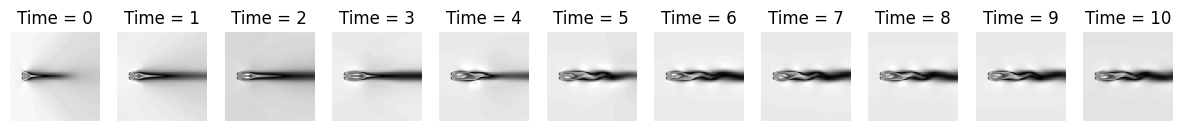

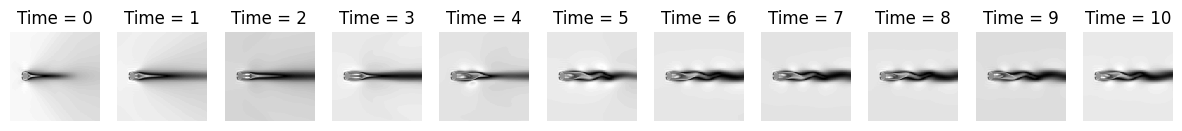

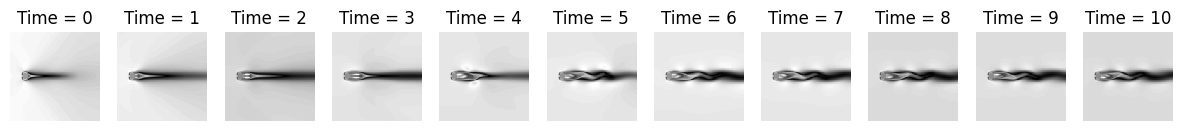

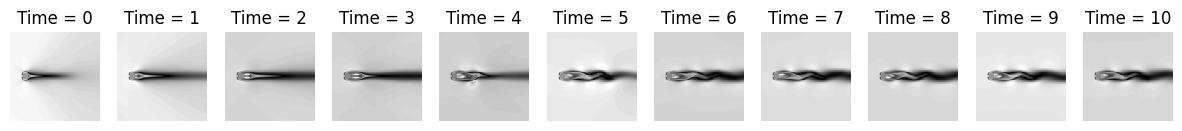

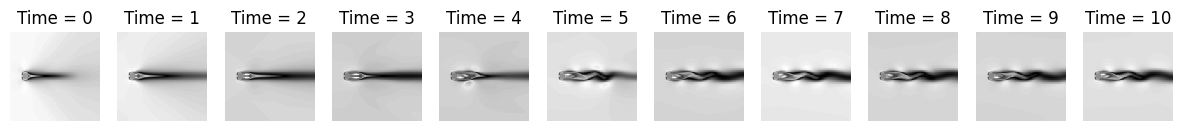

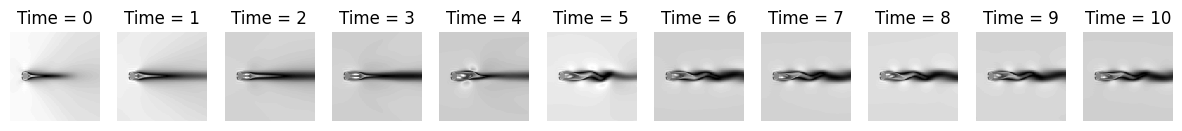

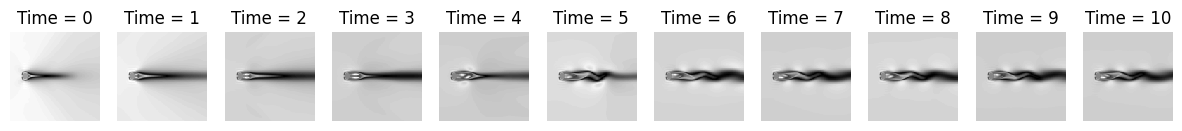

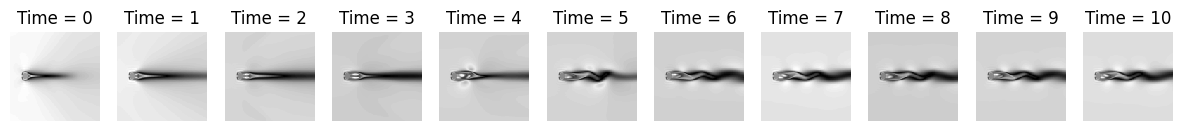

In [30]:
# Plotting imagem from every example
# Config for the sizes of the boxes to be ploted
boxSizeX = 15
boxSizeY = 11
# Looping through all Reynolds numbers
for ReynoldsNumber in range(len(ImagesReynolds3DGrey)):
    # Setting the boxes sizes
    fig = plt.figure(figsize=[boxSizeX,boxSizeY])
    # Looping throuhg all times 
    for time in range(len(ImagesReynolds3DGrey[ReynoldsNumber])):
        # Subplotting every box with 11 timesteps for one example
        plt.subplot(1, 11, time + 1)
        # Looping to open every image 
        for image in ImagesReynolds3DGrey[ReynoldsNumber][time]:
            # if time == 0 or time == 4 or time == 9:
            plt.axis('off')
            # Showing every image stored in the array
            plt.imshow(ImagesReynolds3DGrey[ReynoldsNumber][time], cmap=plt.cm.gray_r, interpolation='nearest')
            # Plotting its images' time step 
            plt.title('Time = %d'%int(time))
    plt.show()
    fig.savefig("Post-Processing/images/DatasetGrey/Dataset" + str(ReynoldsNumber+1) +".png")

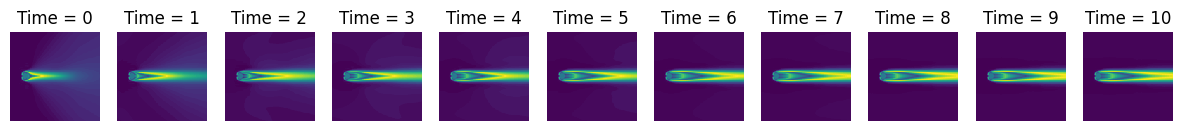

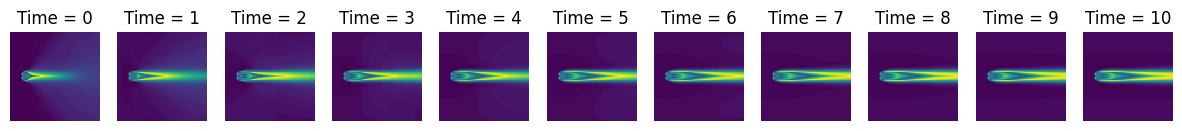

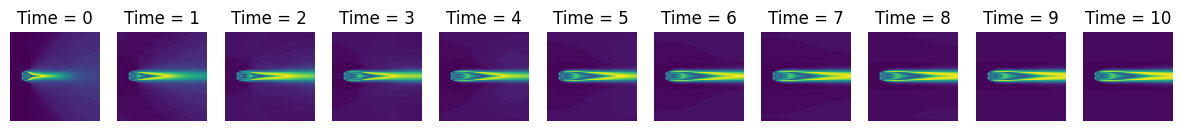

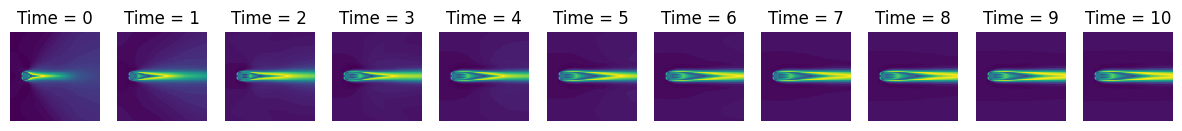

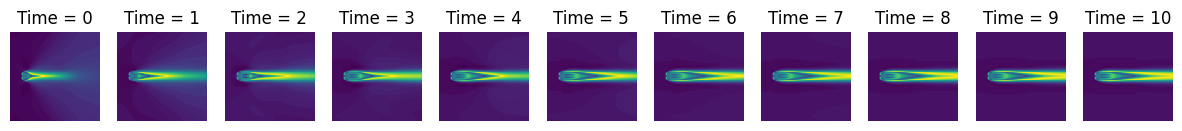

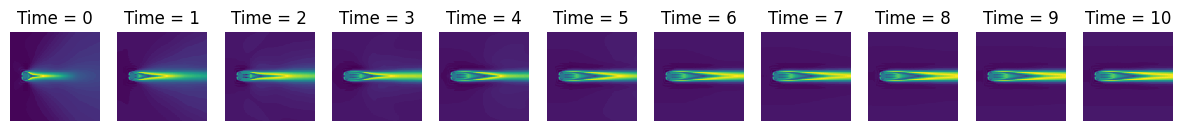

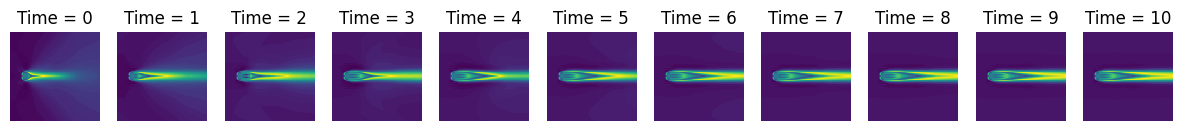

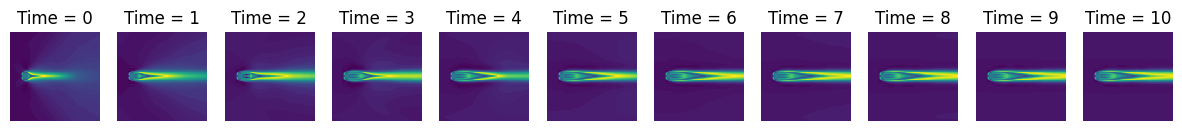

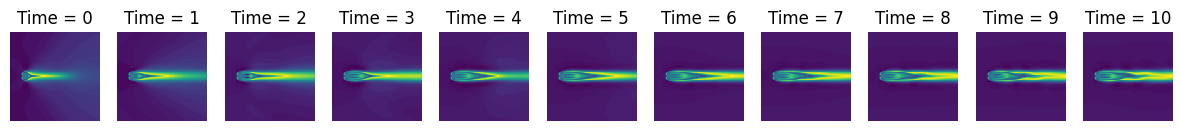

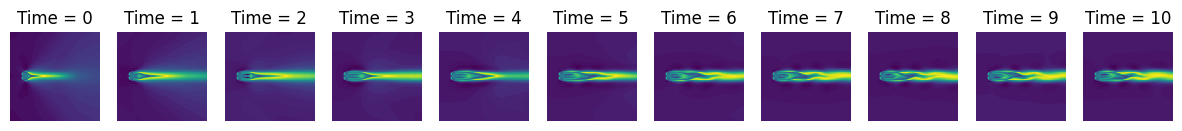

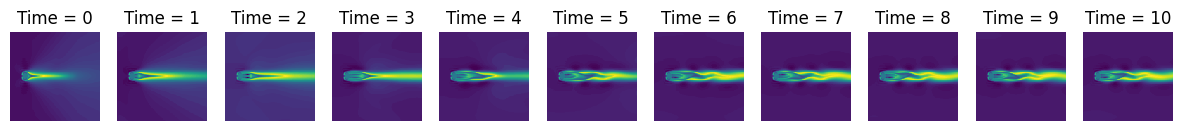

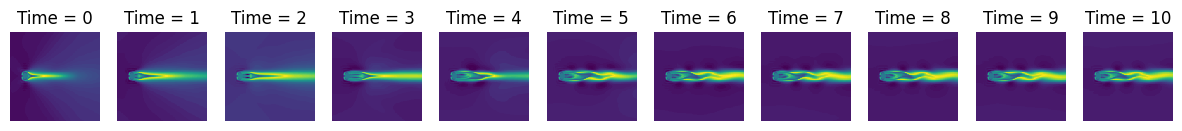

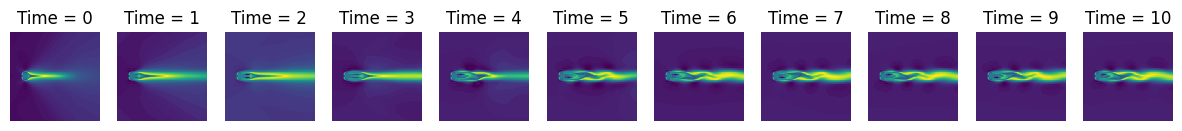

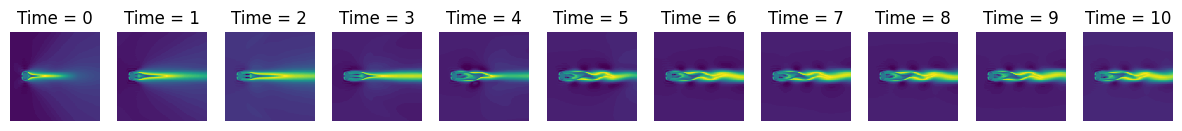

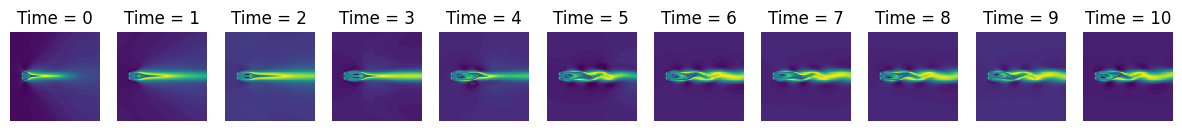

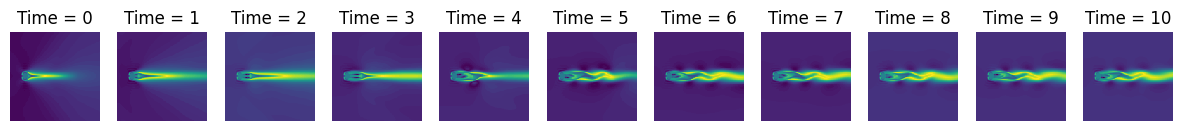

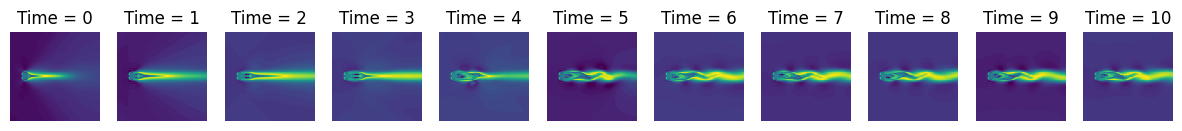

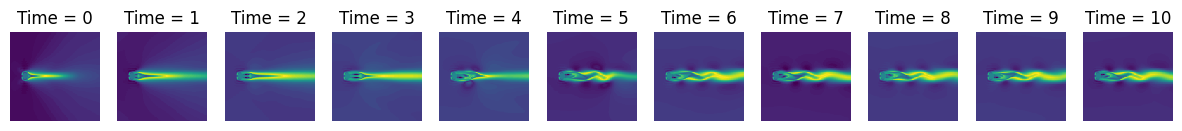

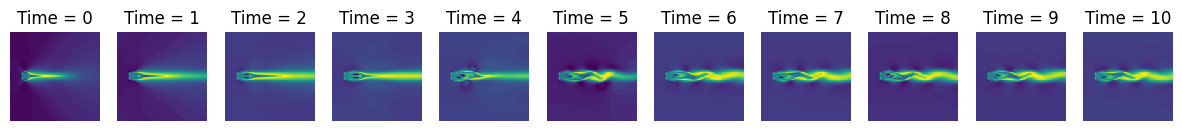

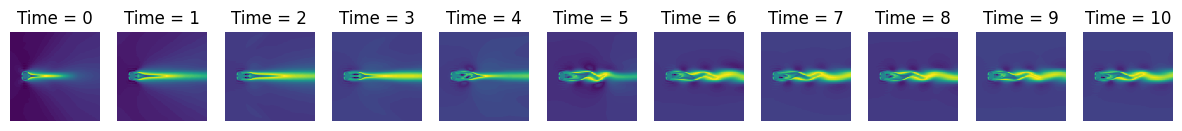

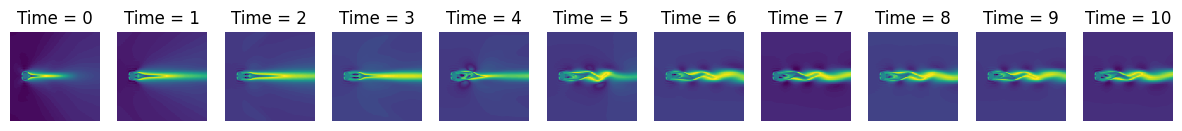

In [31]:
# Plotting imagem from every example
# Config for the sizes of the boxes to be ploted
boxSizeX = 15
boxSizeY = 11
# Looping through all Reynolds numbers
for ReynoldsNumber in range(len(ImagesReynolds3DNormal)):
    # Setting the boxes sizes
    fig = plt.figure(figsize=[boxSizeX,boxSizeY])
    # Looping throuhg all times 
    for time in range(len(ImagesReynolds3DNormal[ReynoldsNumber])):
        # Subplotting every box with 11 timesteps for one example
        plt.subplot(1, 11, time + 1)
        # Looping to open every image 
        for image in ImagesReynolds3DNormal[ReynoldsNumber][time]:
            # if time == 0 or time == 4 or time == 9:
            plt.axis('off')
            # Showing every image stored in the array
            plt.imshow(ImagesReynolds3DNormal[ReynoldsNumber][time], interpolation='nearest')
            # Plotting its images' time step 
            plt.title('Time = %d'%int(time))
    plt.show()
    fig.savefig("Post-Processing/Images/DatasetNorm/DatasetNorm" + str(ReynoldsNumber+1) +".png")

In [189]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", kernel_initializer="he_normal", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [190]:
DefaultConv2DTranspose = partial(tf.keras.layers.Conv2DTranspose, kernel_size=3, strides=1, padding="SAME", kernel_initializer="he_normal", use_bias=False)

class ResidualUnitTranspose(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2DTranspose(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2DTranspose(filters),
            tf.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2DTranspose(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [493]:
keras.backend.clear_session()
tf.random.set_seed(99)
np.random.seed(99)

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[128, 128, 33]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
# model.add(keras.layers.AvgPool2D(pool_size=3, strides=1, padding="SAME"))
DivisionParameter = 1
filters = 128
i = 0
while i < DivisionParameter:
    model.add(ResidualUnit(filters, strides=2))
    model.add(ResidualUnit(filters, strides=1))
    model.add(ResidualUnit(filters, strides=1))
    # model.add(keras.layers.Dropout(rate=0.5))
    filters = 2*filters
    i = i + 1

filters = filters/2
j = 0
while j < DivisionParameter:
    filters = filters/2
    model.add(ResidualUnitTranspose(filters, strides=2))
    model.add(ResidualUnitTranspose(filters, strides=1))
    model.add(ResidualUnitTranspose(filters, strides=1))
    # model.add(keras.layers.Dropout(rate=0.5))
    j = j + 1

# model.add(keras.layers.AvgPool2D(pool_size=3, strides=1, padding="SAME"))
model.add(ResidualUnitTranspose(32, strides=2))
model.add(ResidualUnit(16, strides=2))
model.add(ResidualUnitTranspose(8, strides=2))
model.add(DefaultConv2DTranspose(3, kernel_size=7, strides=1))
# model.add(keras.layers.Dense(3, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        103488    
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 64)        0         
                                                                 
 residual_unit (ResidualUnit  (None, 32, 32, 128)      230912    
 )                                                               
                                                                 
 residual_unit_1 (ResidualUn  (None, 32, 32, 128)      295936    
 it)                                                             
                                                        

In [494]:
depth, version = 26, 1.1
model_type = 'ResNet % dv % d' % (depth, version)

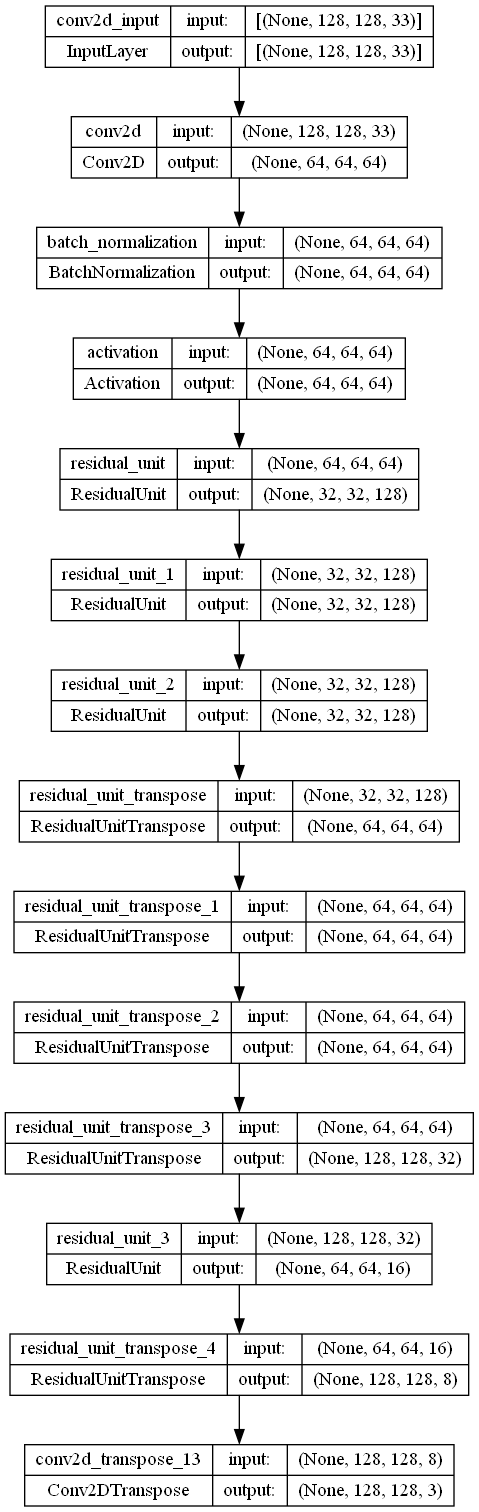

In [564]:
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot_2D.png', show_shapes=True, show_layer_names=True)

In [497]:
import math

def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.1
   epochs_drop = 30.0
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate

def exp_decay(epoch):
   initial_lrate = 0.1
   k = 0.1
   lrate = initial_lrate * exp(-k*t)
   return lrate

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

loss_history = LossHistory()

def lr_schedule(epoch):
    lrate = 1e-3
    if epoch > 170:
        lrate *= 1e-4
    elif epoch > 140:
        lrate *= 1e-3
    elif epoch > 110:
        lrate *= 1e-2
    elif epoch > 80:
        lrate *= 1e-1
    return lrate

In [498]:
# Prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'BurgaoCFD-ML_% s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [499]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(min_delta = 0.001, monitor ='val_loss', patience = 10, restore_best_weights=True)

#checkpoint = ModelCheckpoint(filepath = filepath, monitor ='loss', verbose = 1, save_best_only = True)
  
lr_scheduler = LearningRateScheduler(step_decay)
# lr_scheduler = LearningRateScheduler(lr_schedule)
  
lr_reducer = ReduceLROnPlateau(factor = np.sqrt(0.1), monitor ='val_loss', cooldown = 0, patience = 10, min_lr = 0.5e-6)
  
# callbacks = [early_stopping, loss_history, lr_reducer, lr_scheduler]
# callbacks = [early_stopping, lr_reducer, lr_scheduler]
callbacks = [early_stopping, lr_scheduler]

In [508]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=step_decay(0), beta_1=0.9, beta_2=0.999, epsilon=1e-07)
# optimizer = tf.keras.optimizers.SGD(learning_rate=step_decay(0), momentum=0.9, nesterov=True, decay=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, decay=0.001)
metrics = ["mae","mse", "accuracy"]
model.compile(loss="mse", optimizer=optimizer, metrics=metrics)

In [501]:
#data_train, data_test, target_train, target_test
data_train.shape

(16, 11, 128, 128, 3)

In [502]:
target_train.shape

(16, 1, 128, 128, 3)

In [503]:
ImagesReynolds3DNew = np.concatenate([data_train[:,a,:,:,:] for a in range(11)], axis=3)
ImagesReynolds3DNewTarget = np.concatenate([target_train[:,b,:,:,:] for b in range(1)], axis=3)

In [504]:
ImagesReynolds3DNew.shape

(16, 128, 128, 33)

In [505]:
ImagesReynolds3DNewTarget.shape

(16, 128, 128, 3)

In [506]:
ImagesReynolds3DNewTest = np.concatenate([data_test[:,a,:,:,:] for a in range(11)], axis=3)
ImagesReynolds3DNewTargetTest = np.concatenate([target_test[:,b,:,:,:] for b in range(1)], axis=3)

In [469]:
ImagesReynolds3DNewTest.shape

(5, 128, 128, 33)

In [470]:
ImagesReynolds3DNewTargetTest.shape

(5, 128, 128, 3)

In [571]:
# history = model.fit(ImagesReynolds3DNew, ImagesReynolds3DNewTarget, epochs=200, callbacks=callbacks, validation_split=0.125)
history = model.fit(ImagesReynolds3DNew, ImagesReynolds3DNewTarget, epochs=200, validation_split=0.125)
# history = model.fit(ImagesReynolds3DNew, ImagesReynolds3DNewTarget, epochs=200, validation_data=(ImagesReynolds3DNewTest, ImagesReynolds3DNewTargetTest))
# history = model.fit(ImagesReynolds3DNew, ImagesReynolds3DNewTarget, epochs=200, validation_data=(ImagesReynolds3DNew, ImagesReynolds3DNewTarget))

Epoch 1/200
1/1 [==============================] - 21s 21s/step - loss: 8.1060 - mae: 1.1371 - mse: 8.1060 - accuracy: 0.9965 - val_loss: 11.8885 - val_mae: 1.6883 - val_mse: 11.8885 - val_accuracy: 0.9938
Epoch 2/200
1/1 [==============================] - 18s 18s/step - loss: 8.1147 - mae: 1.1478 - mse: 8.1147 - accuracy: 0.9964 - val_loss: 9.6298 - val_mae: 1.5096 - val_mse: 9.6298 - val_accuracy: 0.9952
Epoch 3/200
1/1 [==============================] - 20s 20s/step - loss: 8.1717 - mae: 1.1458 - mse: 8.1717 - accuracy: 0.9965 - val_loss: 12.7532 - val_mae: 1.7575 - val_mse: 12.7532 - val_accuracy: 0.9938
Epoch 4/200
1/1 [==============================] - 19s 19s/step - loss: 8.2039 - mae: 1.1652 - mse: 8.2039 - accuracy: 0.9964 - val_loss: 9.7089 - val_mae: 1.5172 - val_mse: 9.7089 - val_accuracy: 0.9952
Epoch 5/200
1/1 [==============================] - 19s 19s/step - loss: 8.3144 - mae: 1.1643 - mse: 8.3144 - accuracy: 0.9964 - val_loss: 13.5361 - val_mae: 1.7940 - val_mse: 13.53

In [510]:
# copy weights from one model to another model       
def copyModel2Model(model_source,model_target,certain_layer=""):        
    for l_tg,l_sr in zip(model_target.layers,model_source.layers):
        wk0=l_sr.get_weights()
        l_tg.set_weights(wk0)
        if l_tg.name==certain_layer:
            break
    print("model source was copied into model target") 

def copy_weights2model(w_source,target_model,certain_layer=""):
    l_nm=0
    for layer in target_model.layers:
        w_target=layer.get_weights()
        if len(w_target)>0:
            wk0=[w_source[2*l_nm],w_source[2*l_nm+1]]
            layer.set_weights(wk0)
            l_nm+=1
            if layer.name==certain_layer:
                break

In [580]:
scores = model.evaluate(ImagesReynolds3DNewTest, ImagesReynolds3DNewTargetTest, verbose = 1)
# scores = model.evaluate(ImagesReynolds3DNew, ImagesReynolds3DNewTarget, verbose = 1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[3])

1/1 [==============================] - 2s 2s/step - loss: 17.5994 - mae: 2.0455 - mse: 17.5994 - accuracy: 0.9949
Test loss: 17.59939956665039
Test accuracy: 0.9949096441268921


Minimum Validation Loss: 6.8668
Maximum Validation Accuracy: 0.9969
Minimum Validation MAE: 1.0615
Minimum Validation MSE: 6.8668


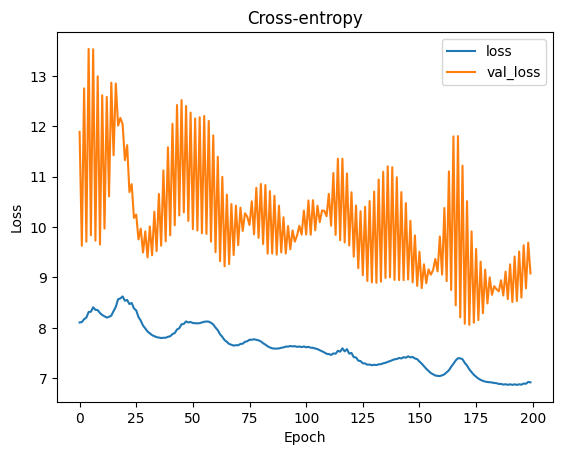

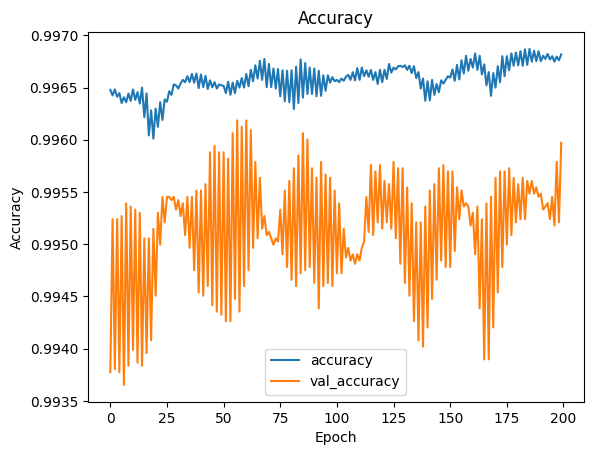

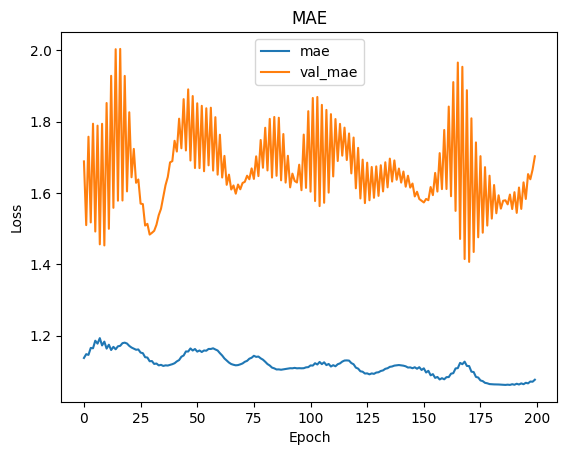

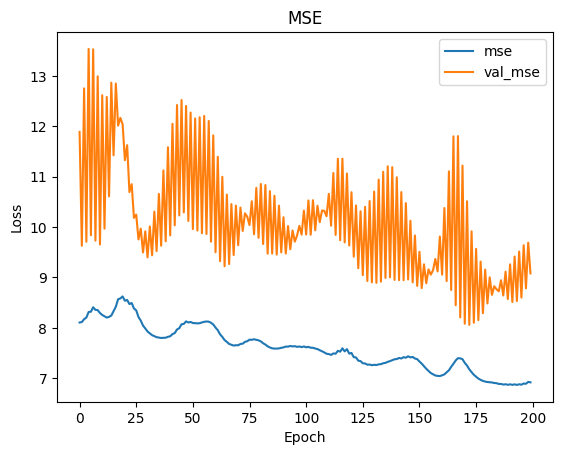

In [581]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("Cross-entropy.png")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("Accuracy.png")
history_df.loc[:, ['mae', 'val_mae']].plot(title="MAE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("MAE.png")
history_df.loc[:, ['mse', 'val_mse']].plot(title="MSE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("MSE.png")
print(("Minimum Validation Loss: {:0.4f}").format(history_df['loss'].min()))
print(("Maximum Validation Accuracy: {:0.4f}").format(history_df['accuracy'].max()))
print(("Minimum Validation MAE: {:0.4f}").format(history_df['mae'].min()))
print(("Minimum Validation MSE: {:0.4f}").format(history_df['mse'].min()))

In [574]:
predictions = model.predict(ImagesReynolds3DNewTest)
# predictions = model.predict(ImagesReynolds3DNew)

1/1 [==============================] - 3s 3s/step


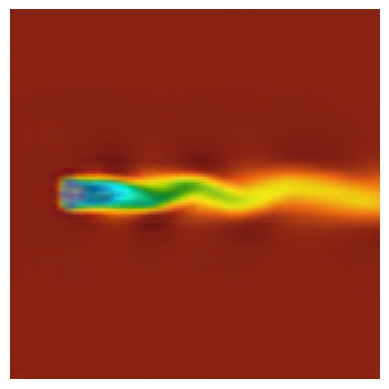

(5, 128, 128, 3)

In [575]:
imageNormalization(predictions[3], True, False)
predictions.shape

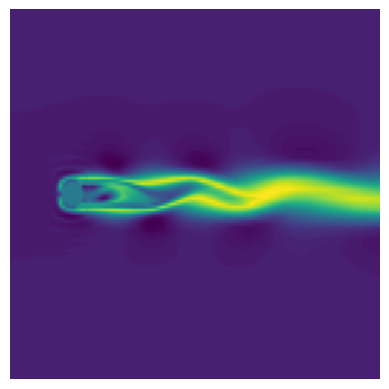

(5, 128, 128, 3)

In [576]:
imageNormalization(Image.fromarray(ImagesReynolds3DNewTargetTest[3]).convert('L'), True, False)
# print(ImagesReynolds3DNewTarget.shape)
# imageNormalization(Image.fromarray(ImagesReynolds3DNewTarget[3]).convert('L'), True, False)
ImagesReynolds3DNewTargetTest.shape

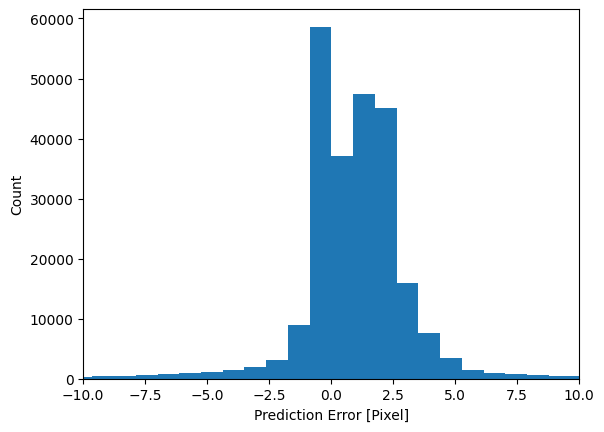

In [584]:
error = predictions.flatten() - ImagesReynolds3DNewTargetTest.flatten()
plt.hist(error, bins = 250)
plt.xlabel("Prediction Error [Pixel]")
plt.xlim([-10, 10])
_ = plt.ylabel("Count")
plt.savefig("hist.png")

In [640]:
import sys
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import norm
from PIL import ImageChops

def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar" the two images are
	return err

def mae(imageA, imageB):
	err = np.sum(abs(imageA.astype("float") - imageB.astype("float")))
	err /= float(imageA.shape[0] * imageA.shape[1])

	return err
	
def compare_images(imageA, imageB, title1, title2, error = False, is_grey = False):
	# compute the mean squared error, mean absolute error and structural similarity measure
	# index for the images
	m = mse(imageA, imageB)
	a = mae(imageA, imageB)
	if is_grey:
		s = ssim(imageA, imageB)
	else:
		s = ssim(imageA, imageB, channel_axis=2)
	# setup the figure
	fig = plt.figure("Images")
	plt.suptitle("MSE: %.6f, MAE: %.6f, SSIM: %.6f" % (m, a, s))
	# show first image
	ax = fig.add_subplot(1, 3, 1)
	ax.set_title(title1)
	plt.imshow(imageA)
	plt.axis("off")
	# show the second image
	ax = fig.add_subplot(1, 3, 2)
	ax.set_title(title2)
	plt.imshow(imageB)
	plt.axis("off")
	if error:
		ax = fig.add_subplot(1, 3, 3)
		ax.set_title("Error")
		plt.imshow(abs(imageA - imageB))
		plt.axis("off")
	# show the images
	plt.show()

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng

def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return np.average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

def compare_images2(img1, img2, normal = False):
    # normalize to compensate for exposure difference, this may be unnecessary consider disabling it
	if normal:
		img1 = normalize(img1)
		img2 = normalize(img2)
    # calculate the difference and its norms
	diff = img1 - img2  # elementwise for scipy arrays
	m_norm = np.sum(abs(diff))  # Manhattan norm
	z_norm = norm(diff.ravel(), 0)  # Zero norm
	return (m_norm, z_norm)


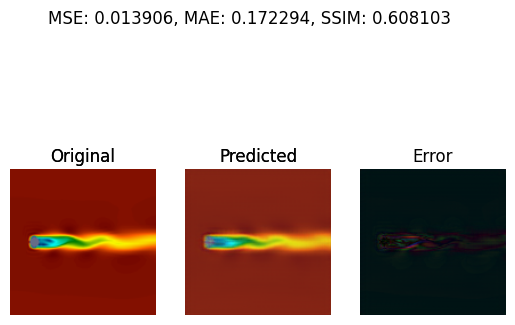

Manhattan norm: 2822.869255288322 / per pixel: 0.057431422023281296
Zero norm: 49150.0 / per pixel: 0.9999593098958334


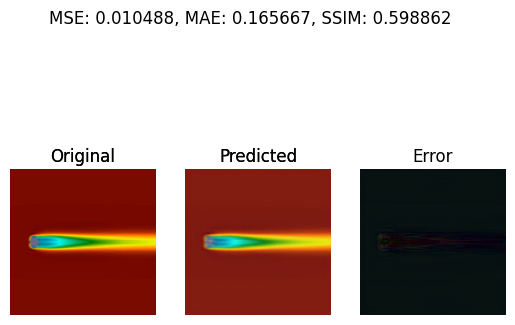

Manhattan norm: 2714.2811095169773 / per pixel: 0.05522219054193069
Zero norm: 49149.0 / per pixel: 0.99993896484375


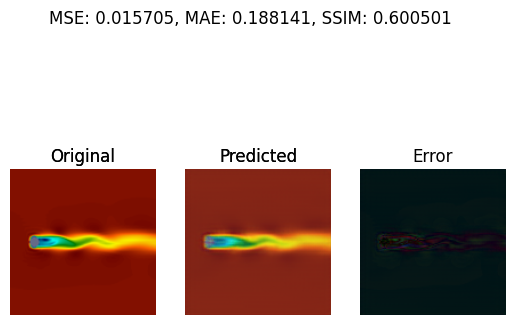

Manhattan norm: 3082.5094213295074 / per pixel: 0.06271381472431452
Zero norm: 49148.0 / per pixel: 0.9999186197916666


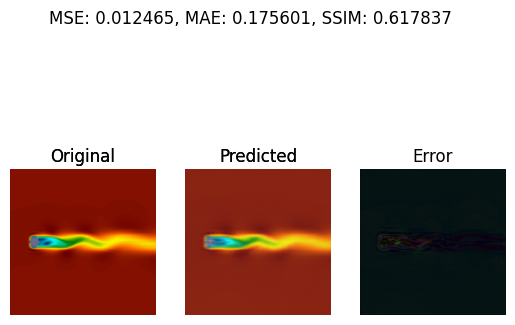

Manhattan norm: 2877.0460784313727 / per pixel: 0.058533652311836194
Zero norm: 49106.0 / per pixel: 0.9990641276041666


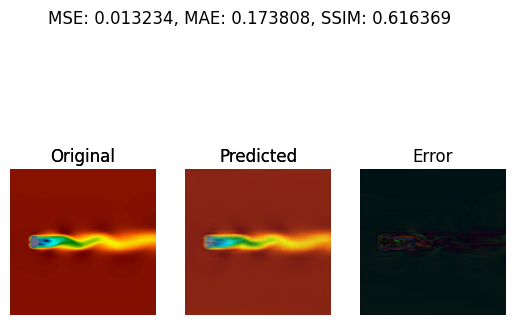

Manhattan norm: 2847.66568627451 / per pixel: 0.05793590670317606
Zero norm: 48738.0 / per pixel: 0.9915771484375


In [641]:
# originals = ImagesReynolds3DNewTarget
originals = ImagesReynolds3DNewTargetTest
k = 0
while k < len(predictions):
	# initialize the figure
	fig = plt.figure("Images")
	# images = ("Original", originals[k]), ("Predicted", imageNormalization(predictions[k], False, False))
	images = ("Original", imageNormalization(originals[k], False, True)), ("Predicted", imageNormalization(imageNormalization(predictions[k], False, False), False, True))
	# loop over the images
	for (i, (name, image)) in enumerate(images):
		# show the image
		ax = fig.add_subplot(1, 3, i + 1)
		ax.set_title(name)
		plt.imshow(image)
		plt.axis("off")

	# compare the images
	is_grey = False
	if is_grey: 
		img3 = to_grayscale(imageNormalization(originals[k], False, True))
		img4 = to_grayscale(imageNormalization(imageNormalization(predictions[k], False, False), False, True))
	else:
		img3 = imageNormalization(originals[k], False, True)
		img4 = imageNormalization(imageNormalization(predictions[k], False, False), False, True)	
	# compare_images(originals[k], imageNormalization(predictions[k], False, False), "Original", "Predicted", True)
	# compare_images(imageNormalization(originals[k], False, True), imageNormalization(imageNormalization(predictions[k], False, False), False, True), "Original", "Predicted", True)
	# compare_images(imageNormalization(imageNormalization(predictions[k], False, False), False, True), imageNormalization(originals[k], False, True), "Original", "Predicted", True)
	compare_images(img3, img4, "Original", "Predicted", True, is_grey)
	
	# compare
	n_m, n_0 = compare_images2(img3, img4)
	print("Manhattan norm:", n_m, "/ per pixel:", n_m/img3.size)
	print("Zero norm:", n_0, "/ per pixel:", n_0*1.0/img3.size)
	# show the figure
	plt.show()
	fig.savefig("Post-Processing/images/Ori-vs-Pred" + str(k+1) +".png")

	k = k + 1